#  Мониторинг процесса обучения

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
* https://docs.wandb.ai/quickstart
* https://docs.wandb.ai/guides/track/log/log-summary#docusaurus_skipToContent_fallback
* https://docs.wandb.ai/guides/track/log/log-models
* https://www.youtube.com/playlist?list=PLD80i8An1OEGajeVo15ohAQYF1Ttle0lk

## Задачи для совместного разбора

In [1]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kekwak. Use `wandb login --relogin` to force relogin


True

1\. Рассмотрите возможности пакета `wandb` по отслеживанию числовых значений, визуализации изображений и таблиц.

In [2]:
import torch as th

def train(num_epochs: int):
    for x in range(num_epochs):
        x = th.tensor(x)
        loss = th.exp(-x/num_epochs)
        r2 = th.randn(size=(1,))
        wandb.log({'train/loss': loss, 'train/r2': r2})
    wandb.run.summary['test/r2'] = 1

In [3]:
with wandb.init(
    project='seminar-tutorial',
    # name='run2',
    tags=['demo'],
    config={'num_epochs': 100}
):
    train(100)

train/loss,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
train/r2,▇▇▆▇▃▆▄▄▇▃▃▇▇▃▄▆█▃▄▆▆▁▄▁▆▅▃▅▅▆█▄▆▇▃▅▆▇▇▇
test/r2,1
train/loss,0.37158
train/r2,-1.01468


In [4]:
import seaborn as sns
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

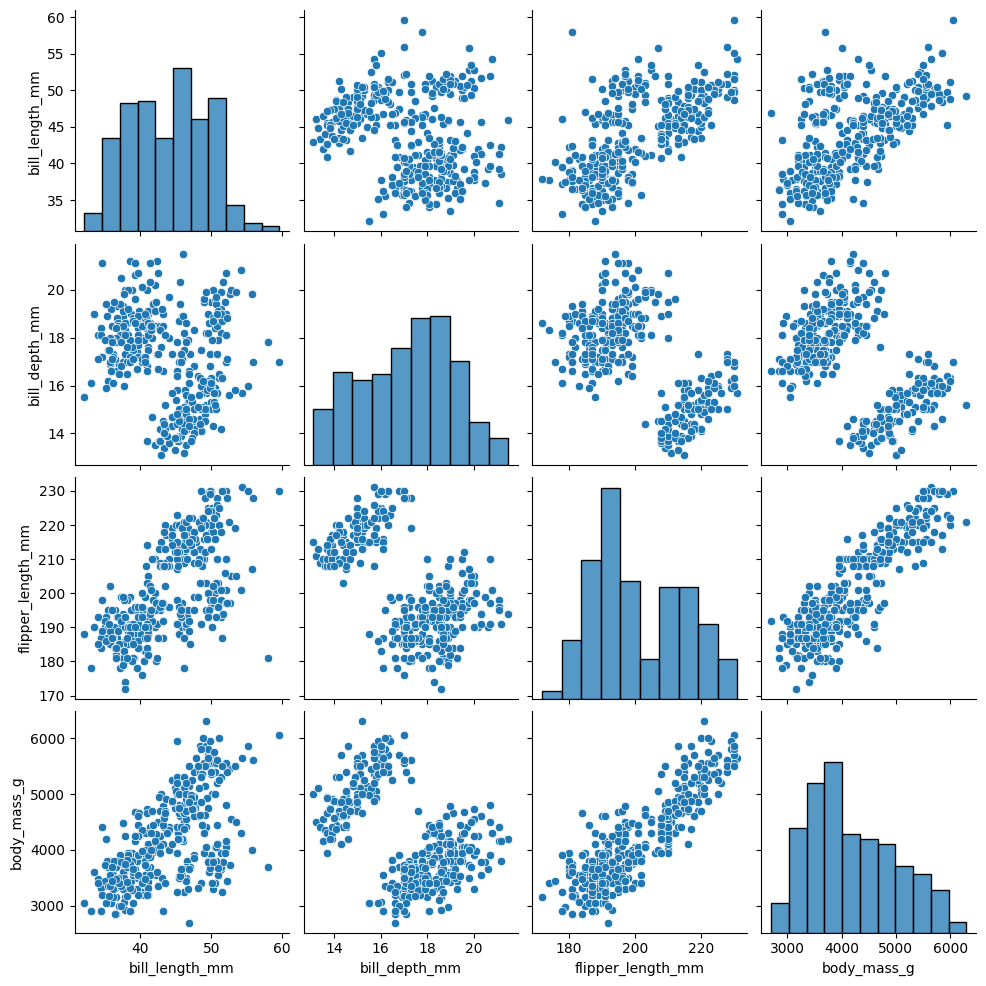

In [5]:
with wandb.init(
    project='seminar-tutorial',
    # name='run2',
    tags=['demo'],
    config={'num_epochs': 100}
):
    dataset = sns.load_dataset('penguins')
    img = sns.pairplot(dataset)
    wandb.log({'train/pairplot': wandb.Image(img.figure)})

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Решите задачу регрессии, используя для мониторинга процесса обучения `wandb`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики $R^2$ по эпохам. После завершения обучения рассчитайте значение метрик MSE, RMSE, MAE и MAPE и сохраните в виде summary данного запуска.

Обучите не менее трех моделей (с разной архитектурой или гиперпараметрами), отследите все запуски при помощи `wandb` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели и summary (страница overview).

- [ ] Проверено на семинаре

In [6]:
import torch as  th

X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [7]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X, y)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

In [8]:
train_X, train_y = dataset_train[:][0], dataset_train[:][1]
test_X, test_y = dataset_test[:][0], dataset_test[:][1]
dataloader_train = DataLoader(dataset_train, batch_size=16)
dataloader_test = DataLoader(dataset_test, batch_size=16)

In [9]:
from torch import nn, optim

model_1 = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.01)
critertion_1 = nn.MSELoss()

model_2 = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)
optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.01)
critertion_2 = nn.MSELoss()

model_3 = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)
optimizer_3 = optim.AdamW(model_3.parameters(), lr=0.01)
critertion_3 = nn.MSELoss()

In [10]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, R2Score

def train(model, optimizer, critertion, num_epochs, print_every=40):
    for epoch in range(1, num_epochs+1):
        model.train()
        for x_b, y_b in dataloader_train:
            y_pred = model(x_b)
            loss = critertion(y_pred, y_b)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        x, y = dataset_train[:][0], dataset_train[:][1]
        with th.no_grad():
            y_pred = model(x)
            loss = critertion(y_pred, y)
            r2 = R2Score()(y_pred, y)

        wandb.log({'train/loss': loss, 'train/r2': r2})
        if epoch % print_every == 0 or epoch == 1:
            print(f'Эпоха {epoch}/{num_epochs}, loss: {loss:.4f}, r2: {r2:.4f}')

    model.eval()
    x, y = dataset_test[:][0], dataset_test[:][1]
    y_pred = model(x)

    metrics = {
        'mse': MeanSquaredError(),
        'rmse': MeanSquaredError(squared=False),
        'mae': MeanAbsoluteError(),
        'mape': MeanAbsolutePercentageError(),
        'r2': R2Score()
    }

    for name, metric in metrics.items():
        wandb.summary[f'test/{name}'] = metric(y_pred, y).item()

In [11]:
config = {'num_epochs': 160, 'print_every': 40}
with wandb.init(
    project='seminar-tutorial',
    name='task-1, model-1',
    tags=['task-1'],
    config=config
):
    train(model_1, optimizer_1, critertion_1, **config)

Эпоха 1/160, loss: 0.3939, r2: 0.1948
Эпоха 40/160, loss: 0.1292, r2: 0.7359
Эпоха 80/160, loss: 0.0930, r2: 0.8099
Эпоха 120/160, loss: 0.0547, r2: 0.8882
Эпоха 160/160, loss: 0.0288, r2: 0.9411


train/loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/r2,▁▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
test/mae,0.20589
test/mape,1.02175
test/mse,0.07969
test/r2,0.83948
test/rmse,0.2823
train/loss,0.02883
train/r2,0.94106


In [12]:
config = {'num_epochs': 200, 'print_every': 50}
with wandb.init(
    project='seminar-tutorial',
    name='task-1, model-2',
    tags=['task-1'],
    config=config
):
    train(model_2, optimizer_2, critertion_2, **config)

Эпоха 1/200, loss: 0.5082, r2: -0.0389
Эпоха 50/200, loss: 0.0816, r2: 0.8333
Эпоха 100/200, loss: 0.0393, r2: 0.9196
Эпоха 150/200, loss: 0.0342, r2: 0.9300
Эпоха 200/200, loss: 0.0340, r2: 0.9305


train/loss,██▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/r2,▁▆▆▆▆▆▆▇▇▇▇▇▇███████████████████████████
test/mae,0.12217
test/mape,0.82243
test/mse,0.04077
test/r2,0.91788
test/rmse,0.20192
train/loss,0.03399
train/r2,0.93052


In [13]:
config = {'num_epochs': 320, 'print_every': 80}
with wandb.init(
    project='seminar-tutorial',
    name='task-1, model-3',
    tags=['task-1'],
    config=config
):
    train(model_3, optimizer_3, critertion_3, **config)

Эпоха 1/320, loss: 0.4940, r2: -0.0099
Эпоха 80/320, loss: 0.0008, r2: 0.9983
Эпоха 160/320, loss: 0.0017, r2: 0.9965
Эпоха 240/320, loss: 0.0014, r2: 0.9972
Эпоха 320/320, loss: 0.0012, r2: 0.9975


train/loss,█▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/r2,▁▅▆▇▇███████████████████████████████████
test/mae,0.04013
test/mape,0.18539
test/mse,0.00214
test/r2,0.99569
test/rmse,0.04626
train/loss,0.00124
train/r2,0.99746


**Графики обучения**<br><br>
![Снимок экрана 2024-10-22 в 20.43.44.png](<attachment:Снимок экрана 2024-10-22 в 20.43.44.png>)

Описание | Скриншоты
---------|----------
**Модель 1:**<br>160 эпох + вывод каждые 40 эпох<br>`Linear(1, 16) -> ReLU() -> Linear(16, 1)` | ![Снимок экрана 2024-10-22 в 20.44.27.png](<attachment:Снимок экрана 2024-10-22 в 20.44.27.png>) ![Снимок экрана 2024-10-22 в 20.44.39.png](<attachment:Снимок экрана 2024-10-22 в 20.44.39.png>)
**Модель 2:**<br>200 эпох + вывод каждые 50 эпох<br>`Linear(1, 32) -> ReLU() -> Linear(32, 4) -> ReLU() -> Linear(4, 1)` | ![Снимок экрана 2024-10-22 в 20.45.28.png](<attachment:Снимок экрана 2024-10-22 в 20.45.28.png>) ![Снимок экрана 2024-10-22 в 20.45.50.png](<attachment:Снимок экрана 2024-10-22 в 20.45.50.png>)
**Модель 3:**<br>320 эпох + вывод каждые 80 эпох<br>`Linear(1, 128) -> ReLU() -> Linear(128, 64) -> ReLU() -> Linear(64, 32) -> ReLU() -> Linear(32, 1)` | ![Снимок экрана 2024-10-22 в 20.46.25.png](<attachment:Снимок экрана 2024-10-22 в 20.46.25.png>) ![Снимок экрана 2024-10-22 в 20.46.41.png](<attachment:Снимок экрана 2024-10-22 в 20.46.41.png>)
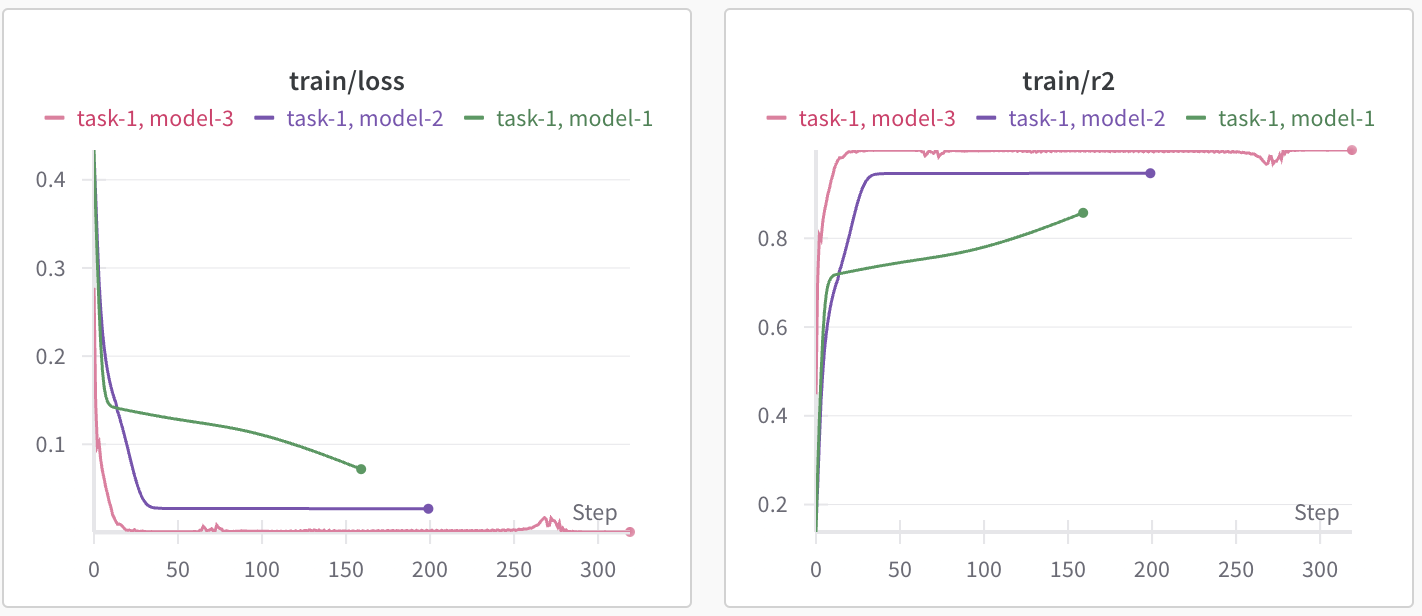
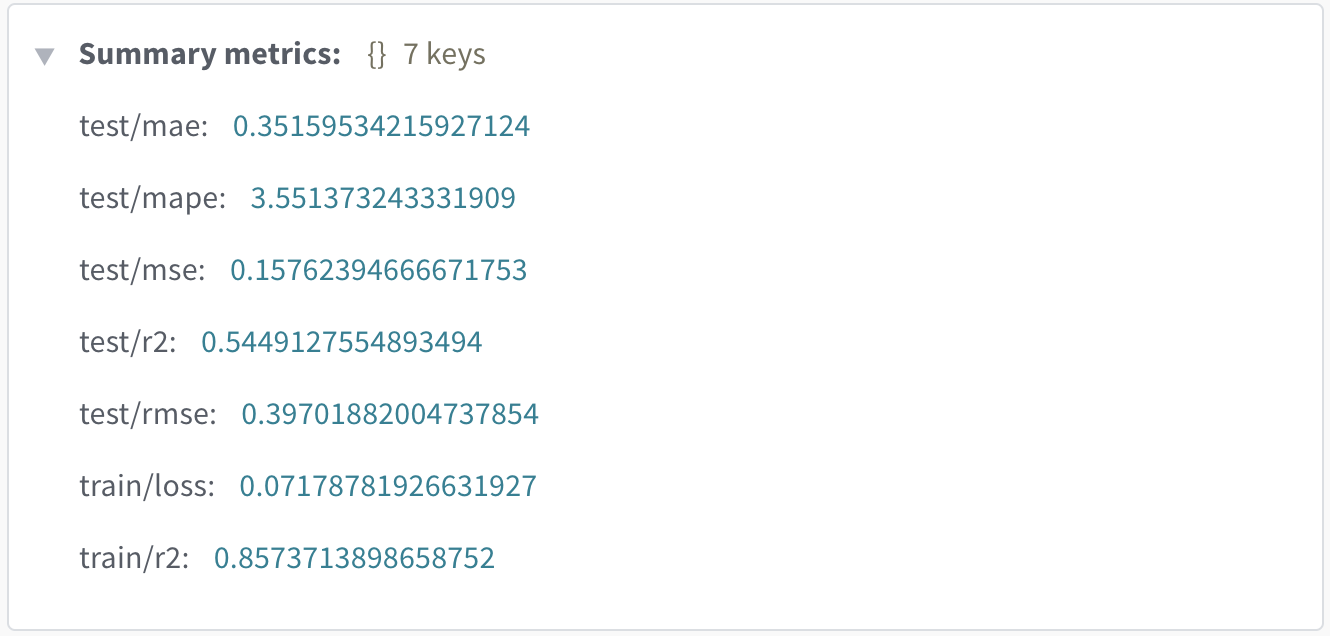
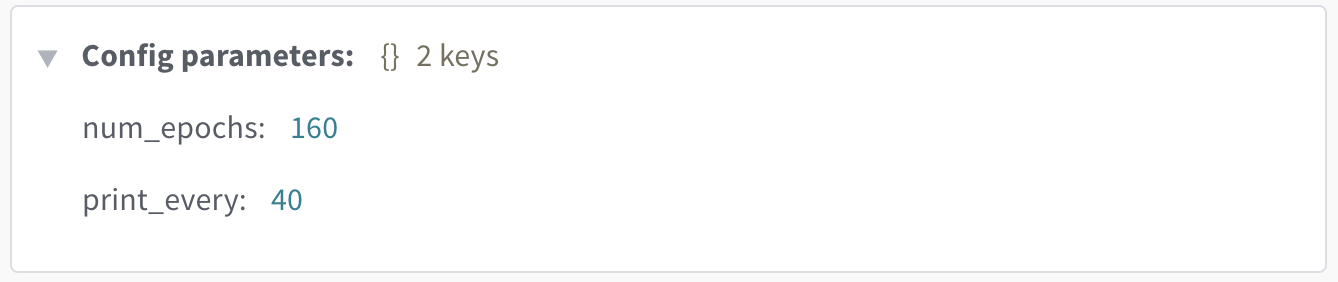
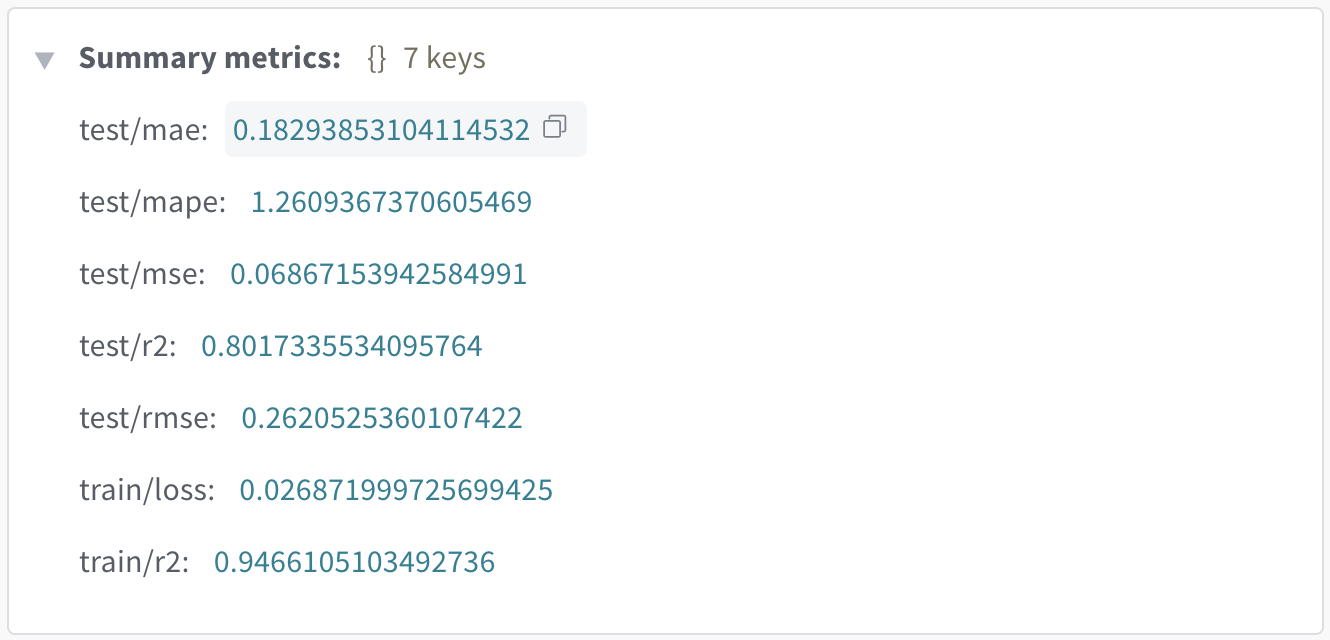
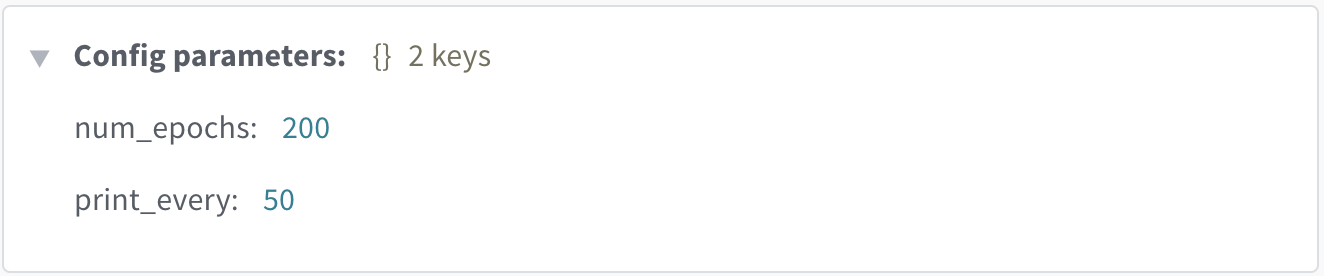
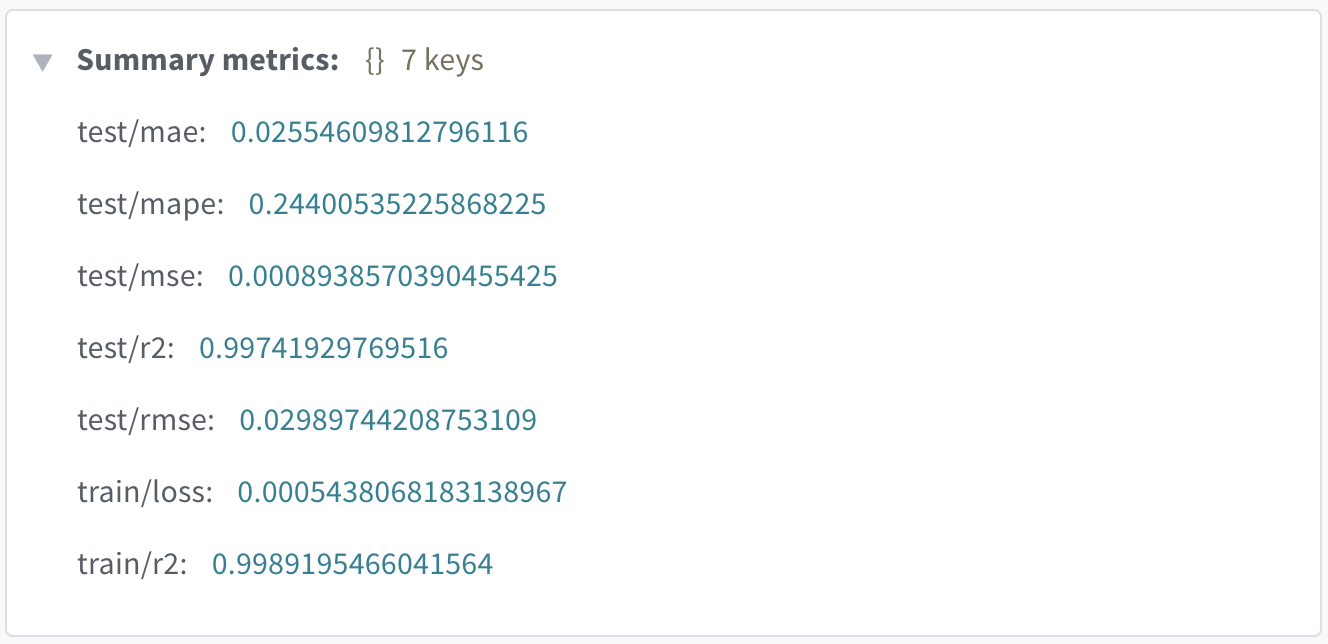
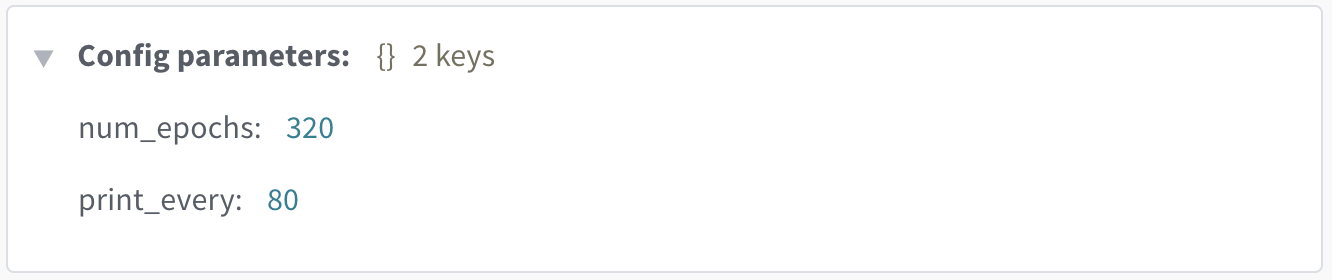

<p class='task' id='2'></p>

2\. Решите задачу классификации, используя для мониторинга процесса обучения `wandb`.

Разделите набор данных на обучающее и тестовое множество. В процессе обучения отслеживайте динамику изменения значения функции потерь и метрики `Accuracy` по эпохам. После завершения обучения рассчитайте значение метрик Accuracy, Precision, Recall и F1 и сохраните в виде summary данного запуска.

Отследите все запуски при помощи `wandb` и вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` с графиками обучения. Для каждого запуска приложите также скриншот с описанием гиперпараметров модели и summary (страница overview).


- [ ] Проверено на семинаре

In [14]:
from sklearn.datasets import make_circles
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

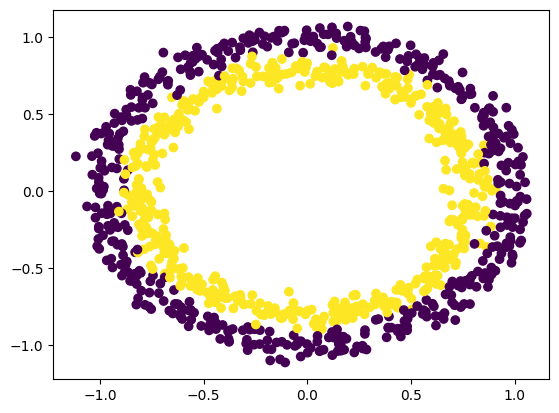

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [16]:
dataset = TensorDataset(X, y)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

In [17]:
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=16)

In [18]:
model_1 = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
)

model_2 = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
)

model_3 = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
)

In [19]:
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.01)
criterion_1 = nn.CrossEntropyLoss()

optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.01)
criterion_2 = nn.CrossEntropyLoss()

optimizer_3 = optim.AdamW(model_3.parameters(), lr=0.01)
criterion_3 = nn.CrossEntropyLoss()

In [20]:
def train(model, optimizer, criterion, num_epochs, print_every=40, model_name='model'):
    accuracy_metric = Accuracy(task='binary')
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        for x_batch, y_batch in dataloader_train:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with th.no_grad():
            X_train, y_train = dataset_train[:][0], dataset_train[:][1]
            y_pred_train = model(X_train)
            loss_train = criterion(y_pred_train, y_train)
            preds = th.argmax(y_pred_train, dim=1)
            acc = accuracy_metric(preds, y_train)
        
        wandb.log({'train/loss': loss_train.item(), 'train/accuracy': acc.item()})
        
        if epoch % print_every == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss_train:.4f}, Accuracy: {acc:.4f}')
    
    model.eval()
    with th.no_grad():
        X_test, y_test = dataset_test[:][0], dataset_test[:][1]
        y_pred_test = model(X_test)
        preds_test = th.argmax(y_pred_test, dim=1)
        
        accuracy = Accuracy(task='binary')(preds_test, y_test)
        precision = Precision(task='binary')(preds_test, y_test)
        recall = Recall(task='binary')(preds_test, y_test)
        f1 = F1Score(task='binary')(preds_test, y_test)
    
    wandb.summary['test/accuracy'] = accuracy.item()
    wandb.summary['test/precision'] = precision.item()
    wandb.summary['test/recall'] = recall.item()
    wandb.summary['test/f1'] = f1.item()

In [21]:
models = [model_1, model_2, model_3]
optimizers = [optimizer_1, optimizer_2, optimizer_3]
criterions = [criterion_1, criterion_2, criterion_3]
configs = [
    {'num_epochs': 160, 'print_every': 40, 'model_name': 'task-2, model-1'},
    {'num_epochs': 200, 'print_every': 50, 'model_name': 'task-2, model-2'},
    {'num_epochs': 320, 'print_every': 80, 'model_name': 'task-2, model-3'},
]

In [22]:
for model, optimizer, criterion, config in zip(models, optimizers, criterions, configs):
    wandb.init(
        project='seminar-tutorial',
        name=config['model_name'],
        tags=['task-2'],
        config=config
    )
    train(model, optimizer, criterion, **config)
    wandb.finish()

Epoch 1/160, Loss: 0.6622, Accuracy: 0.6637
Epoch 40/160, Loss: 0.1005, Accuracy: 0.9775
Epoch 80/160, Loss: 0.0908, Accuracy: 0.9725
Epoch 120/160, Loss: 0.0824, Accuracy: 0.9700
Epoch 160/160, Loss: 0.0796, Accuracy: 0.9737


train/accuracy,▁▂▂▄▇█▇▇████████████████████████████████
train/loss,█▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
test/accuracy,0.98
test/f1,0.97778
test/precision,0.97778
test/recall,0.97778
train/accuracy,0.97375
train/loss,0.0796


Epoch 1/200, Loss: 0.6649, Accuracy: 0.5950
Epoch 50/200, Loss: 0.0786, Accuracy: 0.9725
Epoch 100/200, Loss: 0.0702, Accuracy: 0.9737
Epoch 150/200, Loss: 0.0833, Accuracy: 0.9675
Epoch 200/200, Loss: 0.1087, Accuracy: 0.9525


train/accuracy,▁▆▇▇▇▇█▇▆██▇████▇█▇▇▇▇█▇█▇▇█▇▇▇▇▇▇██▇▇▆▇
train/loss,█▄▃▁▁▂▁▁▁▁▂▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▂▂▁
test/accuracy,0.915
test/f1,0.91371
test/precision,0.84112
test/recall,1
train/accuracy,0.9525
train/loss,0.10874


Epoch 1/320, Loss: 0.6852, Accuracy: 0.5125
Epoch 80/320, Loss: 0.1630, Accuracy: 0.9275
Epoch 160/320, Loss: 0.1495, Accuracy: 0.9362
Epoch 240/320, Loss: 0.0577, Accuracy: 0.9737
Epoch 320/320, Loss: 0.1186, Accuracy: 0.9513


train/accuracy,▇▁▇▅█▇▇▇█▆▅▆█▇█▇▇▇▆▇█▆▇▇█▇▇▅▇█▇▇▇██▇█▆█▆
train/loss,█▂▃▃▂▂▂▁▃▂▆▁▁▂▃▂▁▁▁▂▂▃▃▂▁▂▂▂▁▁▃▁▂▂▂▂▂▃▂▃
test/accuracy,0.945
test/f1,0.94241
test/precision,0.89109
test/recall,1
train/accuracy,0.95125
train/loss,0.11856


**Графики обучения**<br><br>
![Снимок экрана 2024-10-25 в 12.33.03.png](<attachment:Снимок экрана 2024-10-25 в 12.33.03.png>)

Описание | Скриншоты
---------|----------
**Модель 1:**<br>160 эпох + вывод каждые 40 эпох<br>`Linear(1, 16) -> ReLU() -> Linear(16, 2)` | ![Снимок экрана 2024-10-25 в 12.36.26.png](<attachment:Снимок экрана 2024-10-25 в 12.36.26.png>) ![Снимок экрана 2024-10-25 в 12.36.46.png](<attachment:Снимок экрана 2024-10-25 в 12.36.46.png>)
**Модель 2:**<br>200 эпох + вывод каждые 50 эпох<br>`Linear(1, 32) -> ReLU() -> Linear(32, 4) -> ReLU() -> Linear(4, 2)` | ![Снимок экрана 2024-10-25 в 12.34.51.png](<attachment:Снимок экрана 2024-10-25 в 12.34.51.png>) ![Снимок экрана 2024-10-25 в 12.35.10.png](<attachment:Снимок экрана 2024-10-25 в 12.35.10.png>)
**Модель 3:**<br>320 эпох + вывод каждые 80 эпох<br>`Linear(1, 128) -> ReLU() -> Linear(128, 64) -> ReLU() -> Linear(64, 32) -> ReLU() -> Linear(32, 2)` | ![Снимок экрана 2024-10-25 в 12.34.04.png](<attachment:Снимок экрана 2024-10-25 в 12.34.04.png>) ![Снимок экрана 2024-10-25 в 12.34.24.png](<attachment:Снимок экрана 2024-10-25 в 12.34.24.png>)
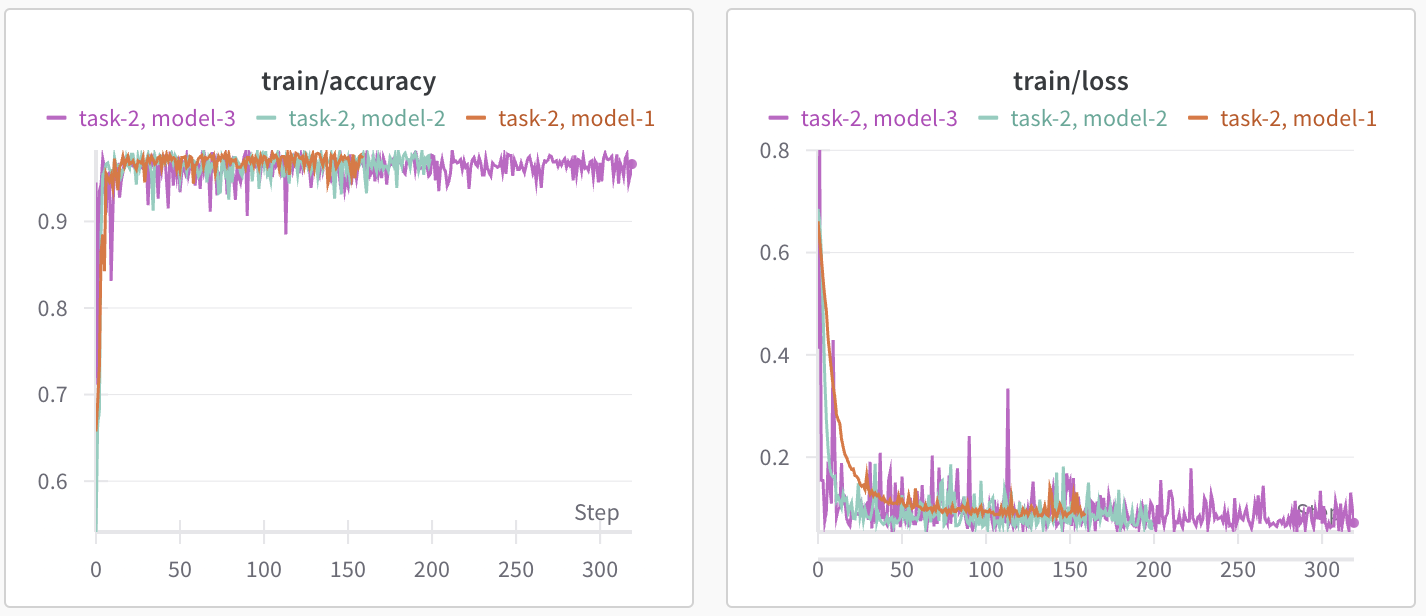
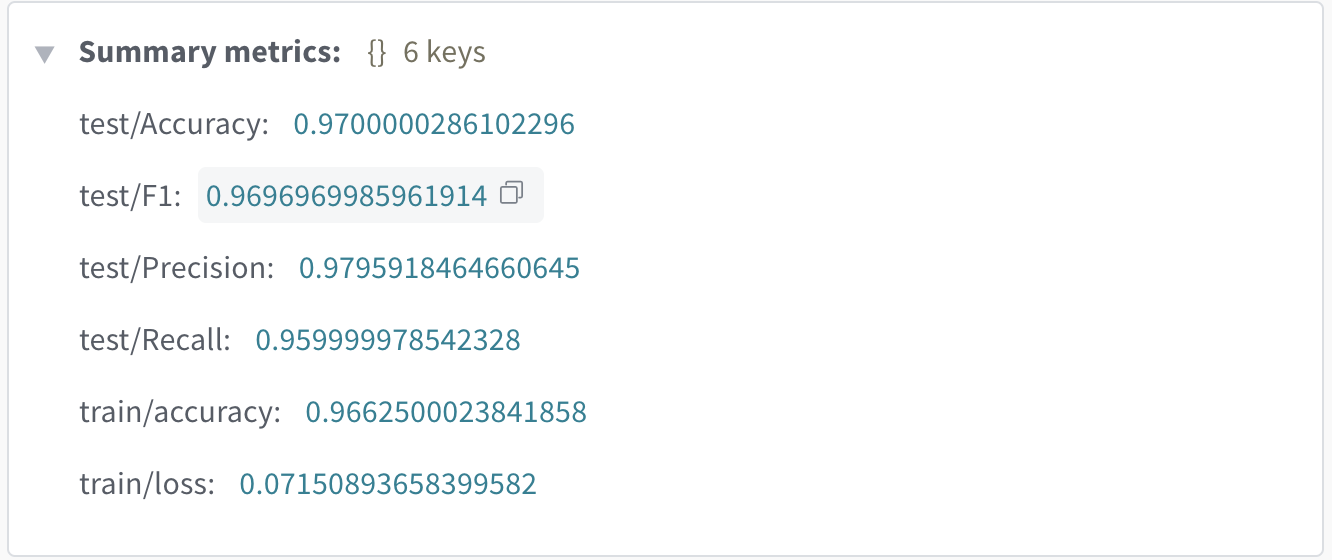
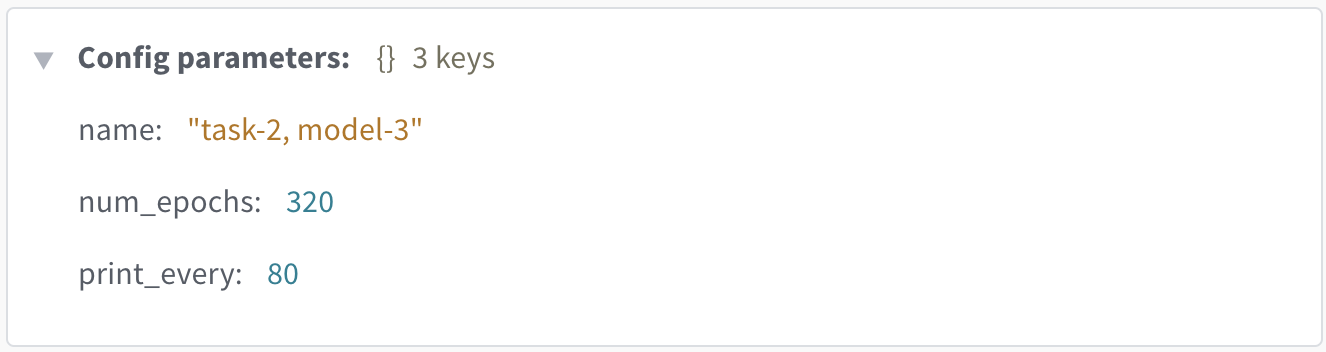
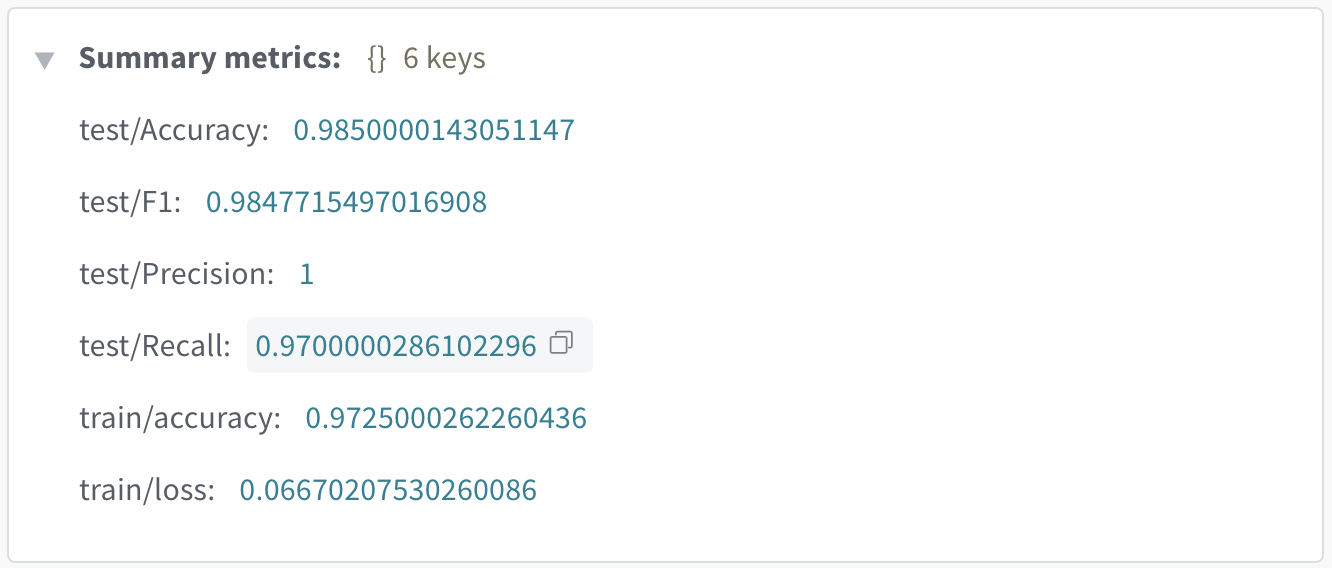
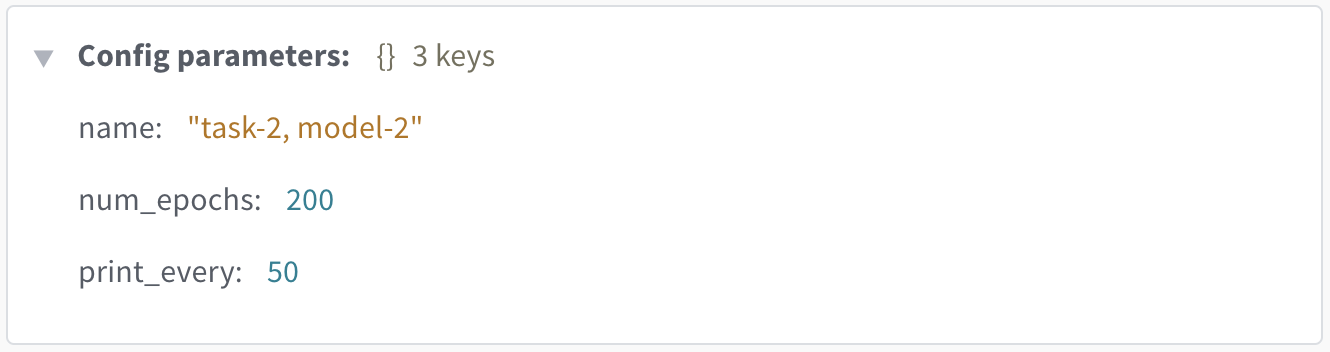
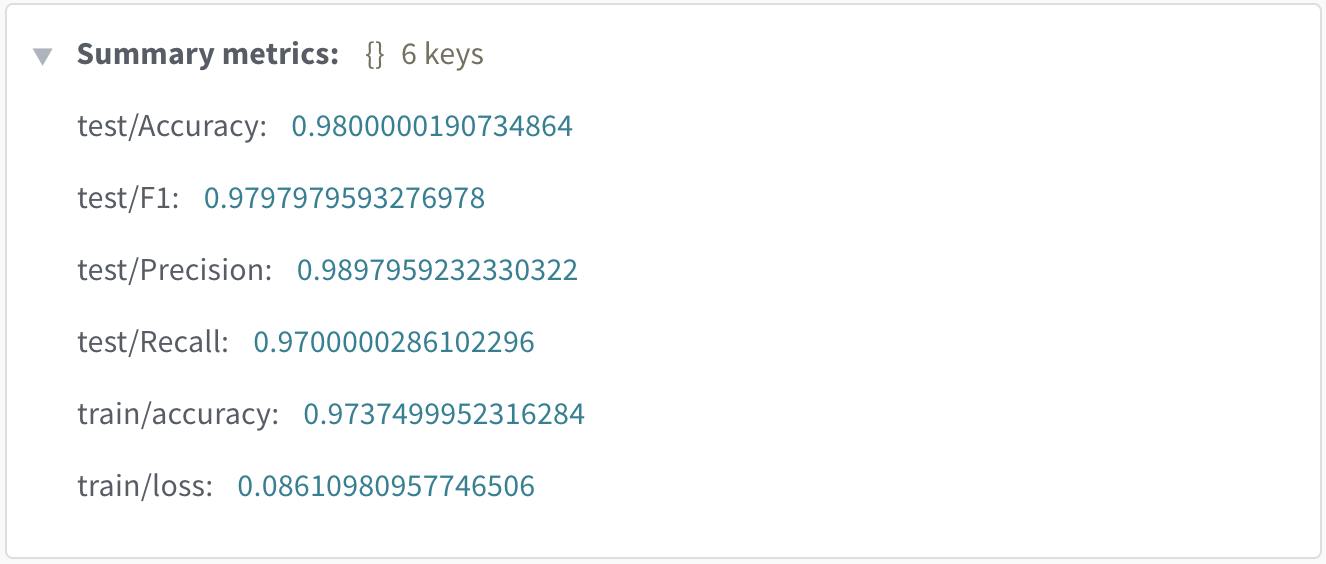
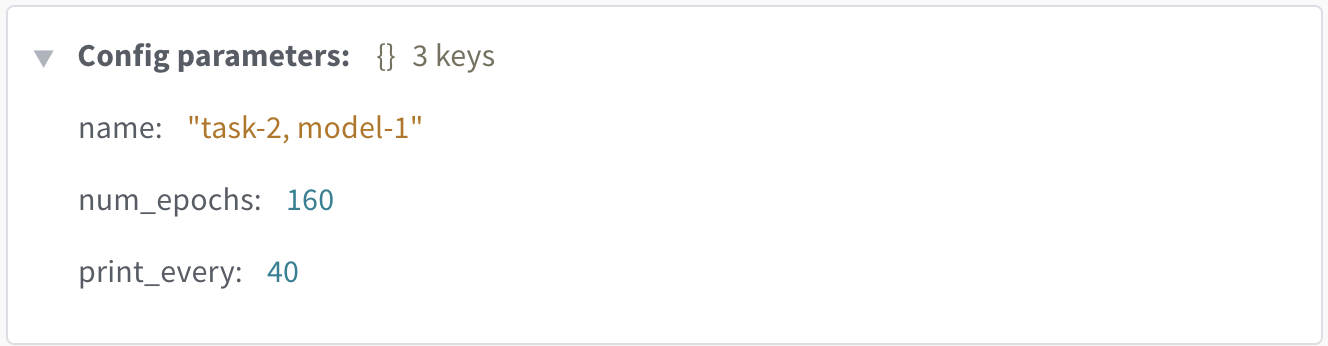

<p class='task' id='3'></p>

3\. Повторите задачу 2, вычислив и визуализировав матрицу несоответствий (для обучающей и тестовой выборки) тремя способами при помощи `wandb`:
* используя `torchmetrics` и представив данные в виде объекта `wandb.Table`;
* используя готовую функцию `wandb.plot.confusion_matrix`;
* построив тепловую карту при помощи `seaborn` и представив данные в виде объекта `wandb.Image`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

In [23]:
from torchmetrics import ConfusionMatrix
import pandas as pd

In [24]:
model_1 = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
)

model_2 = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
)

model_3 = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
)

In [25]:
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.01)
criterion_1 = nn.CrossEntropyLoss()

optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.01)
criterion_2 = nn.CrossEntropyLoss()

optimizer_3 = optim.AdamW(model_3.parameters(), lr=0.01)
criterion_3 = nn.CrossEntropyLoss()

In [26]:
def train(model, optimizer, criterion, num_epochs, print_every=40, model_name='model'):
    accuracy_metric = Accuracy(task='binary')
    for epoch in range(1, num_epochs + 1):
        model.train()
        for x_batch, y_batch in dataloader_train:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with th.no_grad():
            X_train, y_train = dataset_train[:][0], dataset_train[:][1]
            y_pred_train = model(X_train)
            loss_train = criterion(y_pred_train, y_train)
            preds = th.argmax(y_pred_train, dim=1)
            acc = accuracy_metric(preds, y_train)
        
        wandb.log({
            'train/loss': loss_train.item(),
            'train/accuracy': acc.item(),
            'train/confusion_matrix': wandb.plot.confusion_matrix(
                probs=None,
                y_true=y_train.cpu().numpy(),
                preds=preds.cpu().numpy(),
                class_names=['Class 0', 'Class 1']
            )
        })
        
        if epoch % print_every == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss_train:.4f}, Accuracy: {acc:.4f}')
    
    model.eval()
    with th.no_grad():
        X_test, y_test = dataset_test[:][0], dataset_test[:][1]
        y_pred_test = model(X_test)
        preds_test = th.argmax(y_pred_test, dim=1)
        
        accuracy = Accuracy(task='binary')(preds_test, y_test)
        precision = Precision(task='binary')(preds_test, y_test)
        recall = Recall(task='binary')(preds_test, y_test)
        f1 = F1Score(task='binary')(preds_test, y_test)
        
        confusion_test = ConfusionMatrix(task='binary')(preds_test, y_test)
        conf_matrix_df = pd.DataFrame(
            confusion_test.cpu().numpy(), 
            index=['True 0', 'True 1'], 
            columns=['Pred 0', 'Pred 1']
        )
        table = wandb.Table(
            data=conf_matrix_df.values.tolist(),
            columns=conf_matrix_df.columns.tolist()
        )
        
        plt.figure(figsize=(6,5))
        sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Истина')
        plt.xlabel('Предсказание')
        plt.title('Confusion Matrix')
        heatmap_image = plt.gcf()
        plt.close()
        
    wandb.summary['test/accuracy'] = accuracy.item()
    wandb.summary['test/precision'] = precision.item()
    wandb.summary['test/recall'] = recall.item()
    wandb.summary['test/f1'] = f1.item()

    y_test_np = y_test.cpu().numpy()
    preds_test_np = preds_test.cpu().numpy()

    wandb.log({
        'test/confusion_matrix_table': table,
        'test/confusion_matrix_wandb_plot': wandb.plot.confusion_matrix(
            preds=preds_test_np,
            y_true=y_test_np,
            class_names=['Class 0', 'Class 1']
        ),
        'test/confusion_matrix_heatmap': wandb.Image(heatmap_image)
    })

In [27]:
models = [model_1, model_2, model_3]
optimizers = [optimizer_1, optimizer_2, optimizer_3]
criterions = [criterion_1, criterion_2, criterion_3]
configs = [
    {'num_epochs': 60, 'print_every': 20, 'model_name': 'task-3, model-1'},
    {'num_epochs': 40, 'print_every': 20, 'model_name': 'task-3, model-2'},
    {'num_epochs': 30, 'print_every': 15, 'model_name': 'task-3, model-3'},
]

for model, optimizer, criterion, config in zip(models, optimizers, criterions, configs):
    with wandb.init(
        project='seminar-tutorial',
        name=config['model_name'],
        tags=['task-3'],
        config=config
    ):
        train(model, optimizer, criterion, **config)
    wandb.finish()

Epoch 1/60, Loss: 0.6786, Accuracy: 0.5462
Epoch 20/60, Loss: 0.2050, Accuracy: 0.9475
Epoch 40/60, Loss: 0.1111, Accuracy: 0.9712
Epoch 60/60, Loss: 0.0955, Accuracy: 0.9725


train/accuracy,▁▄▆▅▇▇██████████████████████████████████
train/loss,██▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/accuracy,0.945
test/f1,0.94118
test/precision,0.90722
test/recall,0.97778
train/accuracy,0.9725
train/loss,0.0955


Epoch 1/40, Loss: 0.6554, Accuracy: 0.6475
Epoch 20/40, Loss: 0.1051, Accuracy: 0.9675
Epoch 40/40, Loss: 0.1064, Accuracy: 0.9563


train/accuracy,▁▂▇▇█▇██▇▇▇▇███▇█▇██▇█████████▇███▇█████
train/loss,█▇▆▄▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
test/accuracy,0.96
test/f1,0.95652
test/precision,0.93617
test/recall,0.97778
train/accuracy,0.95625
train/loss,0.10637


Epoch 1/30, Loss: 0.6745, Accuracy: 0.5625
Epoch 15/30, Loss: 0.0880, Accuracy: 0.9625
Epoch 30/30, Loss: 0.0926, Accuracy: 0.9650


train/accuracy,▁▄▄█▇▇██▅▇▇▇█▇██▇█████████████
train/loss,█▆▇▂▃▂▁▁▅▂▂▃▁▂▁▁▂▁▁▁▂▁▂▁▂▁▁▂▁▁
test/accuracy,0.955
test/f1,0.95028
test/precision,0.94505
test/recall,0.95556
train/accuracy,0.965
train/loss,0.09263


**Матрицы несоответствий**<br><br>
Описание | Скрин
-|-
Модель 1 | ![Снимок экрана 2024-10-27 в 15.02.23.png](<attachment:Снимок экрана 2024-10-27 в 15.02.23.png>)
Модели 1,2,3 | ![Снимок экрана 2024-10-27 в 15.03.29.png](<attachment:Снимок экрана 2024-10-27 в 15.03.29.png>)
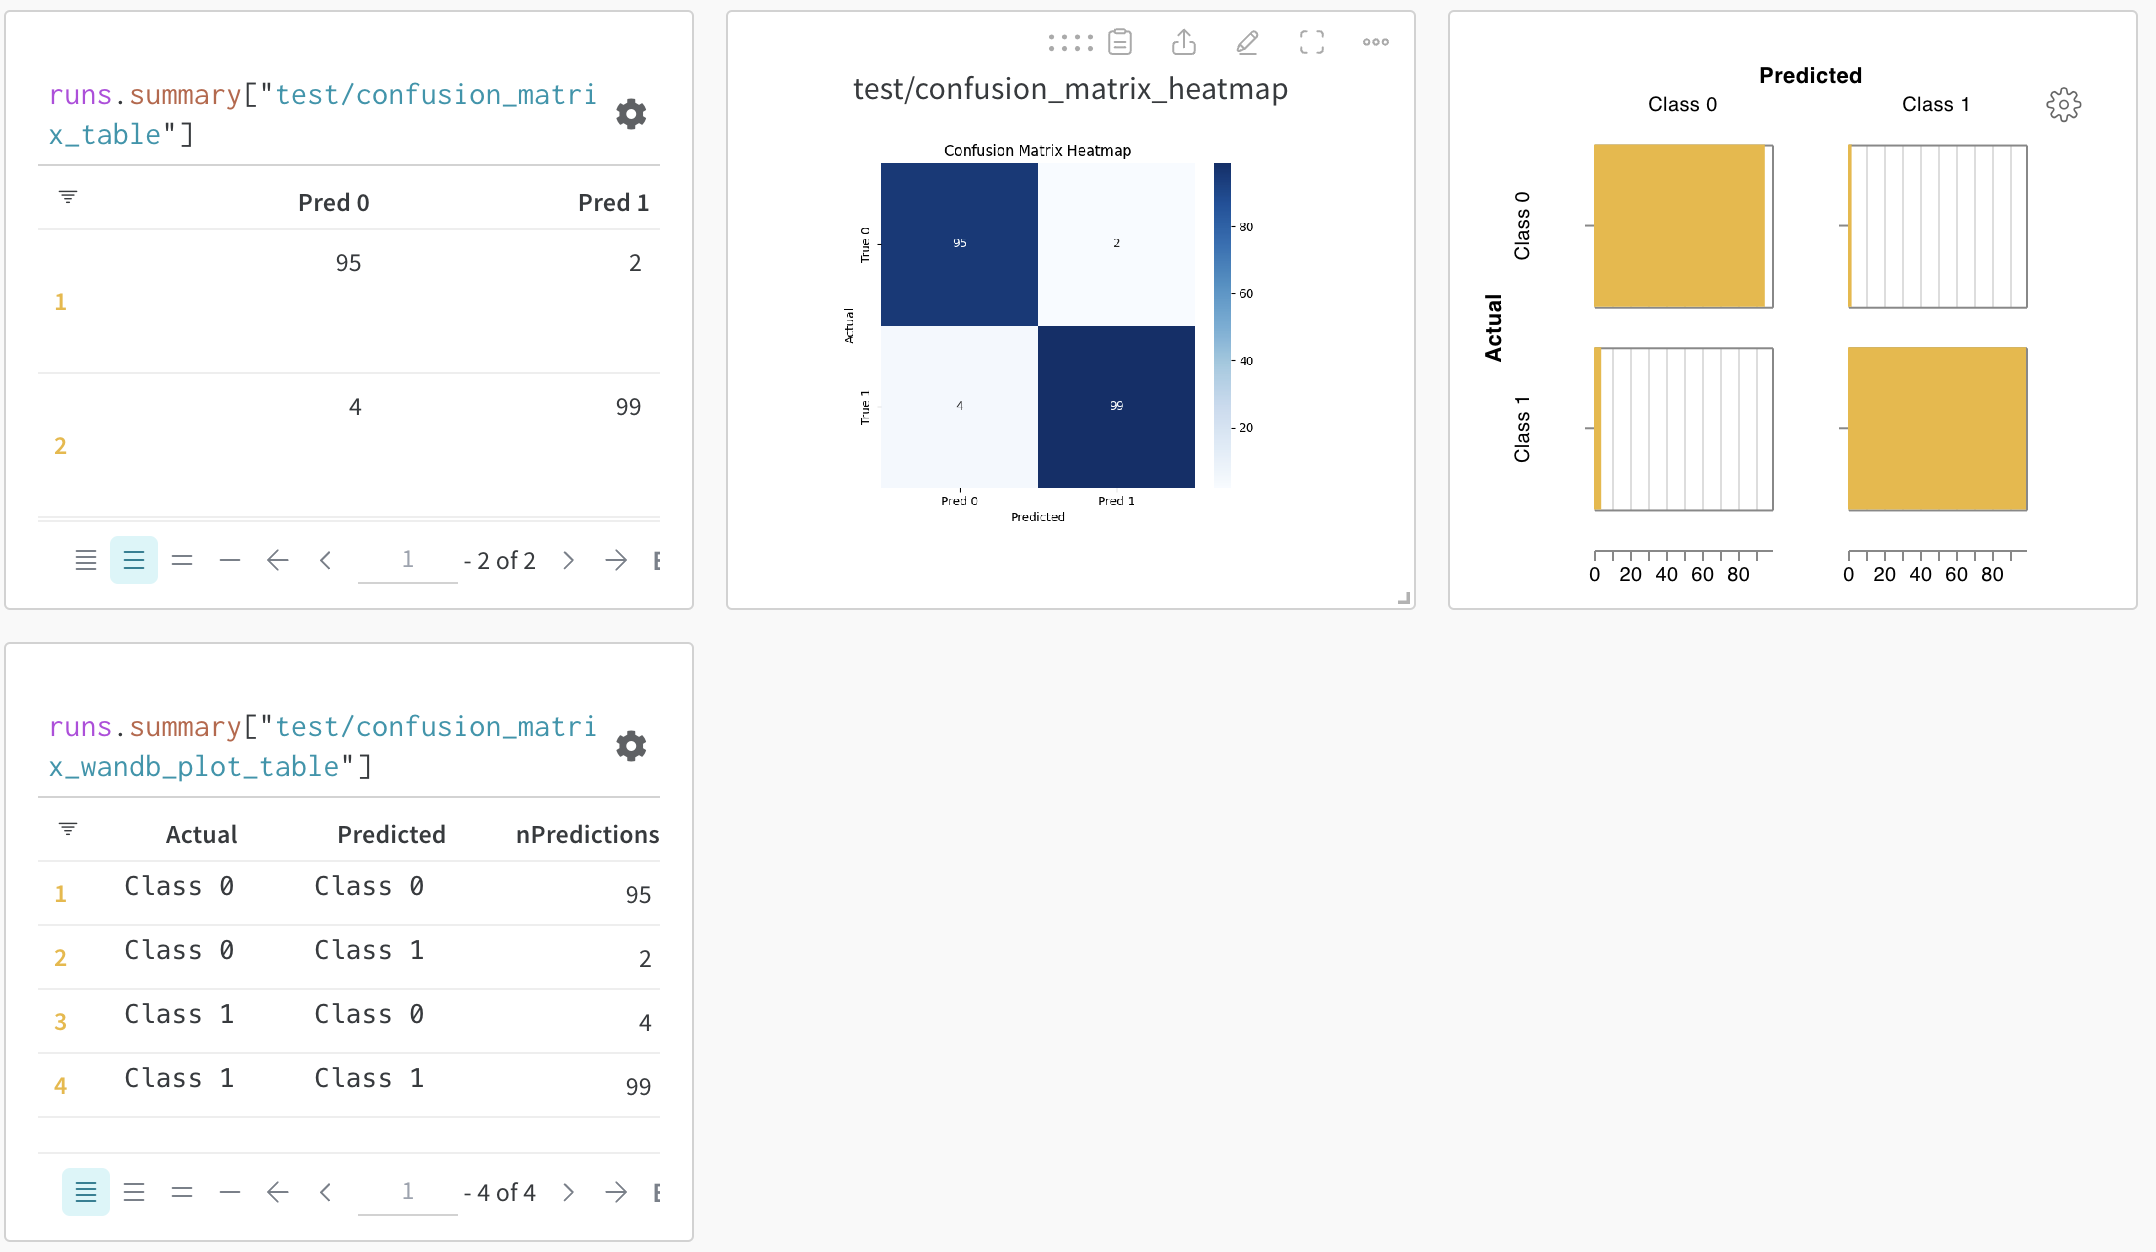
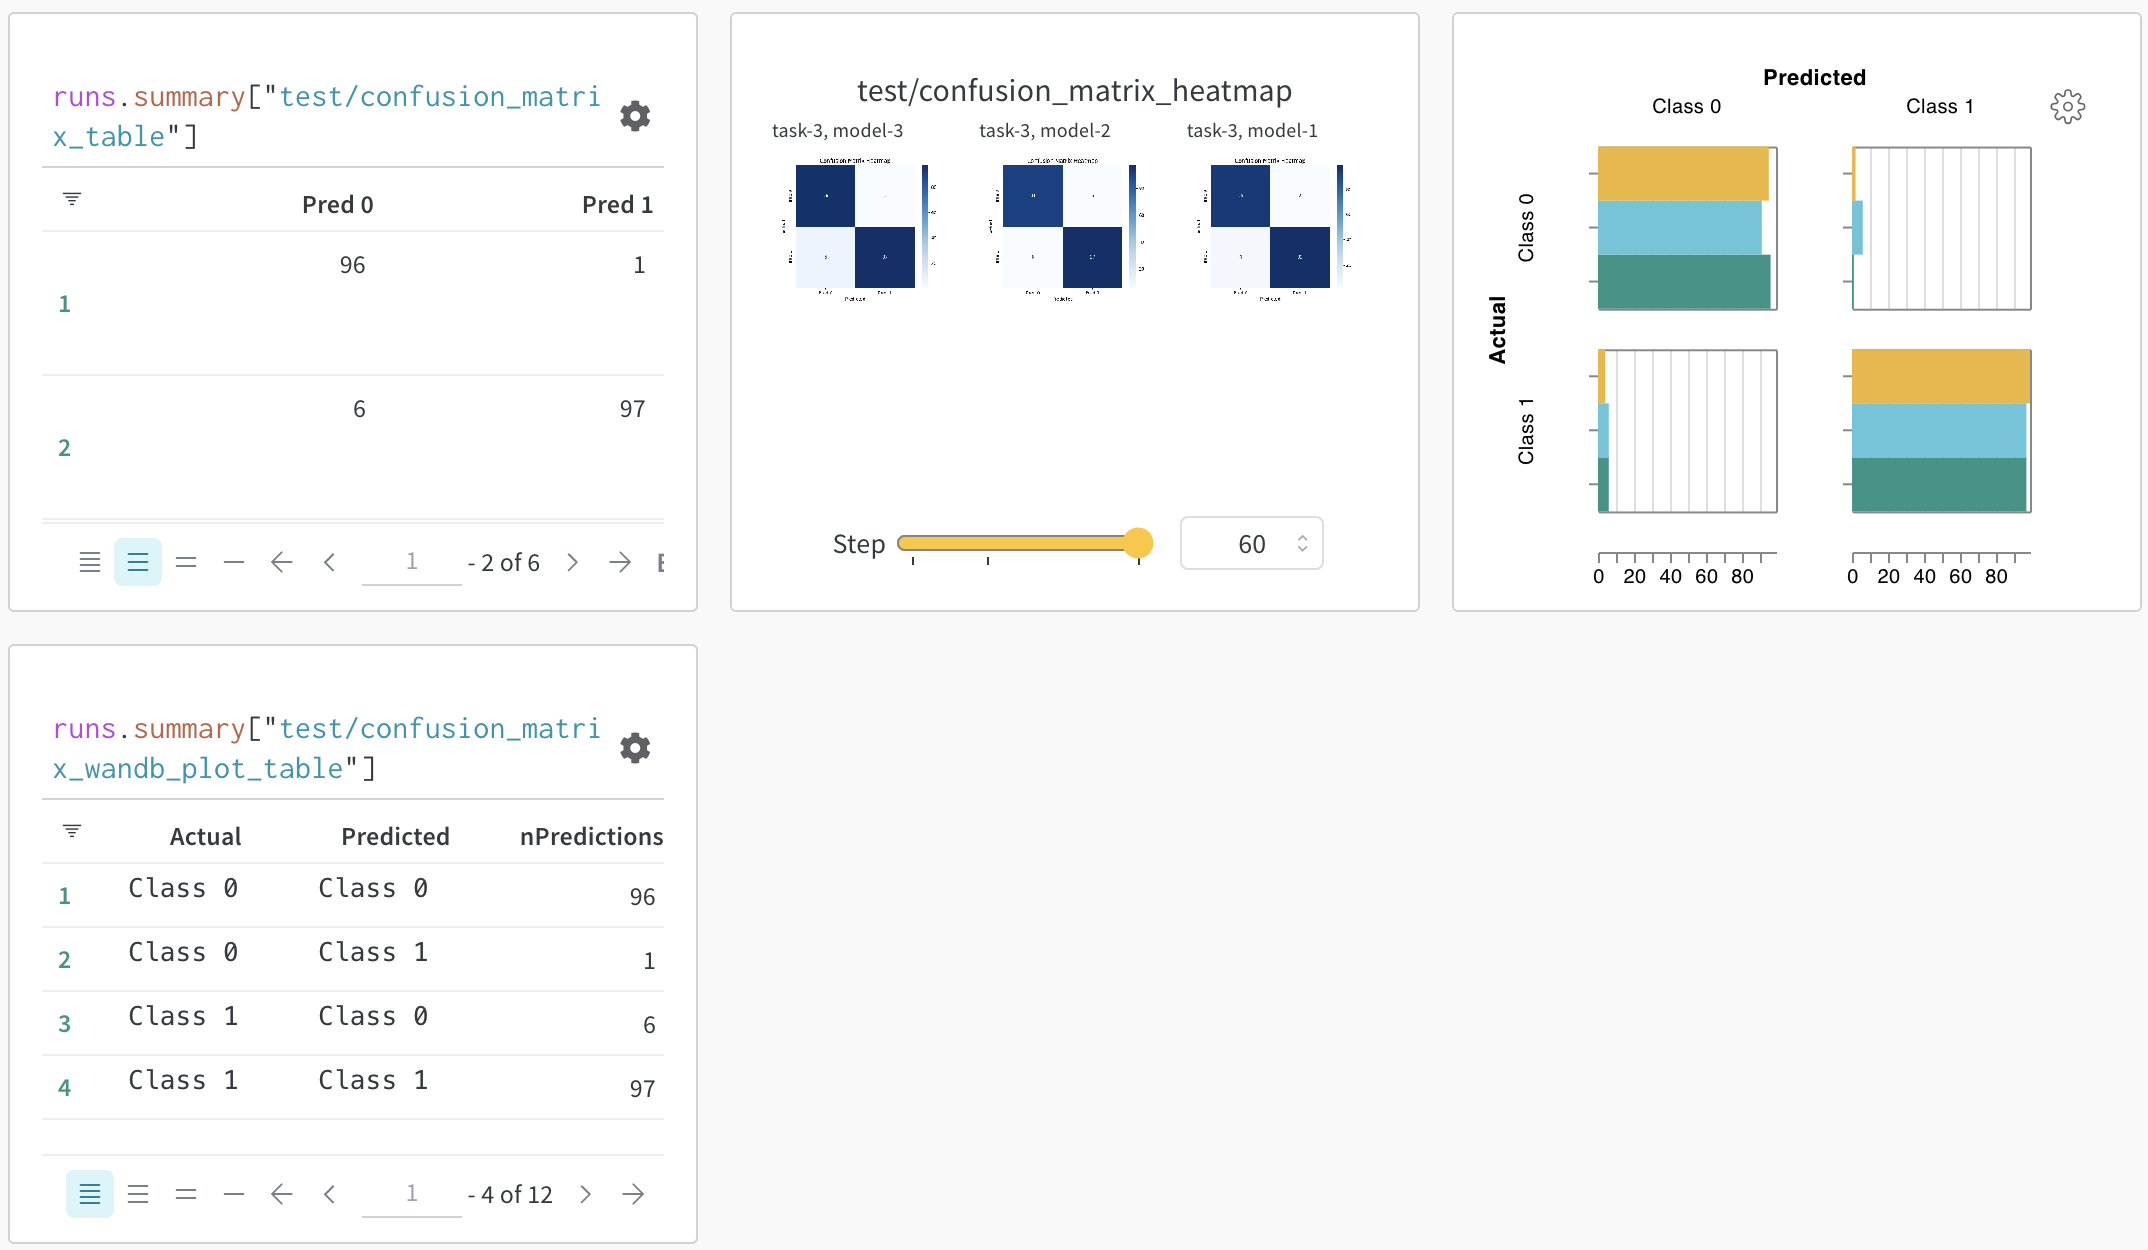

<p class='task' id='4'></p>

4\. Повторите задачу 2, обучив две модели: линейную и нелинейную. Для каждой из моделей сделайте прогноз (по всей выборке) и визуализируйте облако точек в виде `wandb.Image` (раскрасьте точки в цвета, соответствующие прогнозам модели).

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.


- [ ] Проверено на семинаре

In [28]:
lin = nn.Linear(2, 2)
nonlin = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
)

In [29]:
optimizer_linear = optim.AdamW(lin.parameters(), lr=0.01)
criterion_linear = nn.CrossEntropyLoss()

optimizer_nonlinear = optim.AdamW(nonlin.parameters(), lr=0.01)
criterion_nonlinear = nn.CrossEntropyLoss()

In [30]:
def train(model, optimizer, criterion, num_epochs, print_every=40, model_name='model'):
    accuracy_metric = Accuracy(task='binary')
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        for x_batch, y_batch in dataloader_train:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with th.no_grad():
            X_train, y_train = dataset_train[:][0], dataset_train[:][1]
            y_pred_train = model(X_train)
            loss_train = criterion(y_pred_train, y_train)
            preds_train = th.argmax(y_pred_train, dim=1)
            acc_train = accuracy_metric(preds_train, y_train)
        
        wandb.log({'train/loss': loss_train.item(), 'train/accuracy': acc_train.item()}, step=epoch)
        
        if epoch % print_every == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss_train:.4f}, Accuracy: {acc_train:.4f}')
    
    model.eval()
    with th.no_grad():
        X_test, y_test = dataset_test[:][0], dataset_test[:][1]
        y_pred_test = model(X_test)
        preds_test = th.argmax(y_pred_test, dim=1)
        
        accuracy = Accuracy(task='binary')(preds_test, y_test)
        precision = Precision(task='binary')(preds_test, y_test)
        recall = Recall(task='binary')(preds_test, y_test)
        f1 = F1Score(task='binary')(preds_test, y_test)
    
    wandb.summary['test/accuracy'] = accuracy.item()
    wandb.summary['test/precision'] = precision.item()
    wandb.summary['test/recall'] = recall.item()
    wandb.summary['test/f1'] = f1.item()
    
    with th.no_grad():
        X_all, y_all = dataset[:][0], dataset[:][1]
        y_pred_all = model(X_all)
        preds_all = th.argmax(y_pred_all, dim=1)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(X_all[:, 0], X_all[:, 1], c=preds_all.cpu(), alpha=0.5)
    plt.title(model_name)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.tight_layout()
    
    image = plt.gcf()
    plt.close()
    
    wandb.log({'predictions_scatter': wandb.Image(image)})

In [31]:
models = [lin, nonlin]
optimizers = [optimizer_linear, optimizer_nonlinear]
criterions = [criterion_linear, criterion_nonlinear]
configs = [
    {'num_epochs': 60, 'print_every': 20, 'model_name': 'task-4, model-linear'},
    {'num_epochs': 60, 'print_every': 20, 'model_name': 'task-4, model-nonlinear'},
]

In [32]:
for model, optimizer, criterion, config in zip(models, optimizers, criterions, configs):
    wandb.init(
        project='seminar-tutorial',
        name=config['model_name'],
        tags=['task-4'],
        config=config
    )
    train(model, optimizer, criterion, **config)
    wandb.finish()

Epoch 1/60, Loss: 0.6930, Accuracy: 0.5125
Epoch 20/60, Loss: 0.6929, Accuracy: 0.5375
Epoch 40/60, Loss: 0.6927, Accuracy: 0.5587
Epoch 60/60, Loss: 0.6927, Accuracy: 0.5475


train/accuracy,▁▁▁▁█▅▅▁▁▁▂▄▄▁█▂▁▁▄▅▇▁▂▃▄▄▆▁▇▆▁▅▅▁▁█▁▁█▄
train/loss,▆▅▃▄▂▁▂▄▃▃▂▁▆▂█▄▃▁▃▄▂█▂▃▄▁▃▃▂▁▄▂▅▃▃▆▄▂▃▁
test/accuracy,0.485
test/f1,0.57613
test/precision,0.45752
test/recall,0.77778
train/accuracy,0.5475
train/loss,0.69267


Epoch 1/60, Loss: 0.6753, Accuracy: 0.7275
Epoch 20/60, Loss: 0.1769, Accuracy: 0.9650
Epoch 40/60, Loss: 0.1224, Accuracy: 0.9663
Epoch 60/60, Loss: 0.0998, Accuracy: 0.9675


train/accuracy,▃▁▅▆▄▇███████████████████████████████▇██
train/loss,█▇▇▆▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
test/accuracy,0.96
test/f1,0.95745
test/precision,0.91837
test/recall,1
train/accuracy,0.9675
train/loss,0.09982


**Визуализация**<br><br>
Описание | Скрин
-|-
Предсказание | ![Снимок экрана 2024-10-27 в 15.11.12.png](<attachment:Снимок экрана 2024-10-27 в 15.11.12.png>)
Loss | ![Снимок экрана 2024-10-27 в 15.11.16.png](<attachment:Снимок экрана 2024-10-27 в 15.11.16.png>)
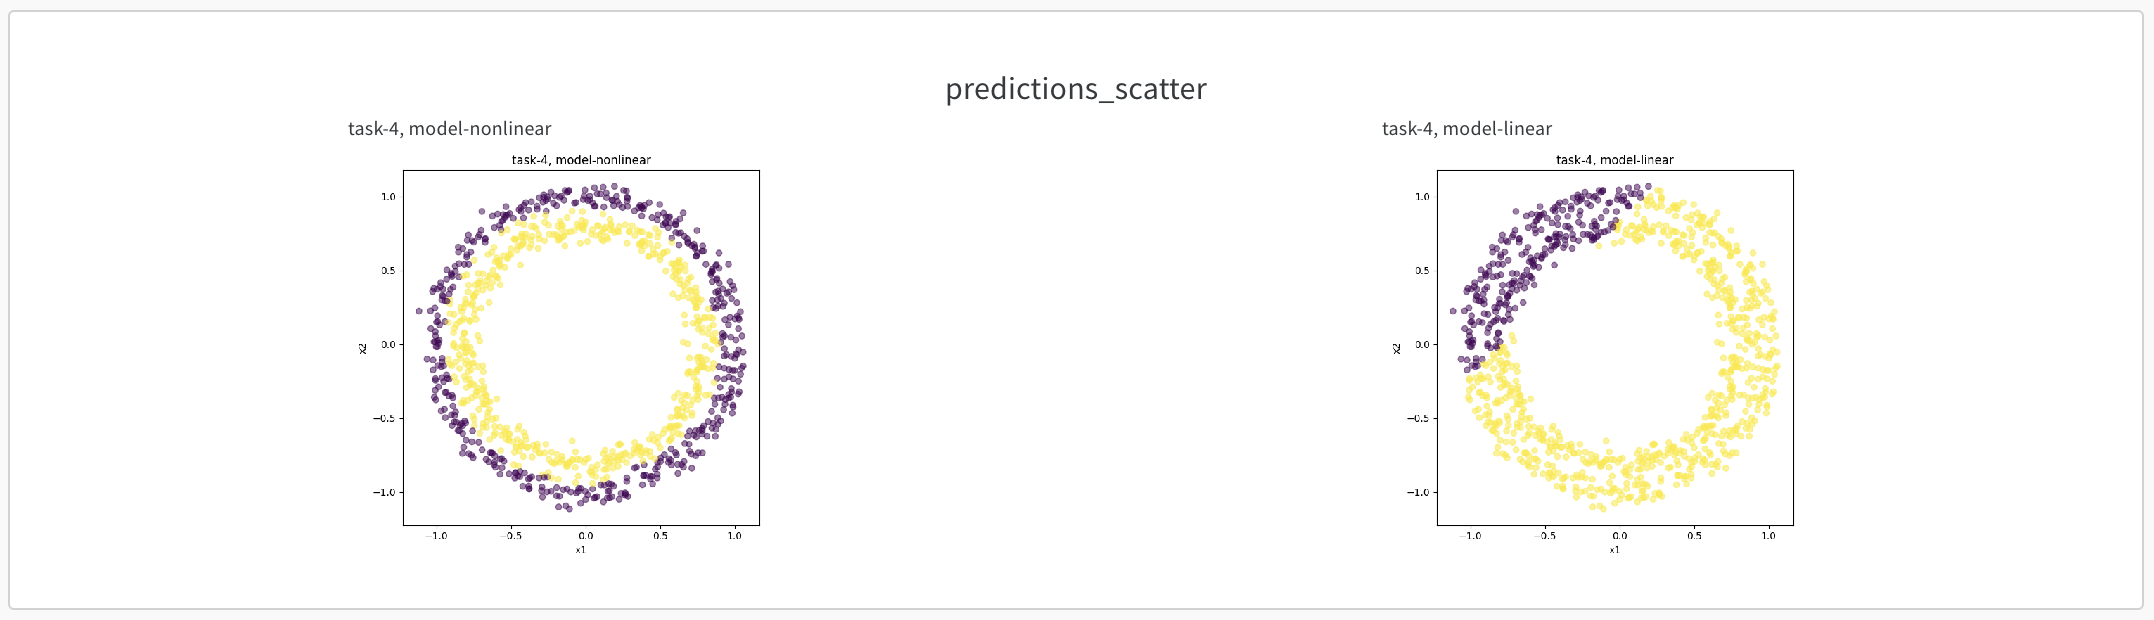
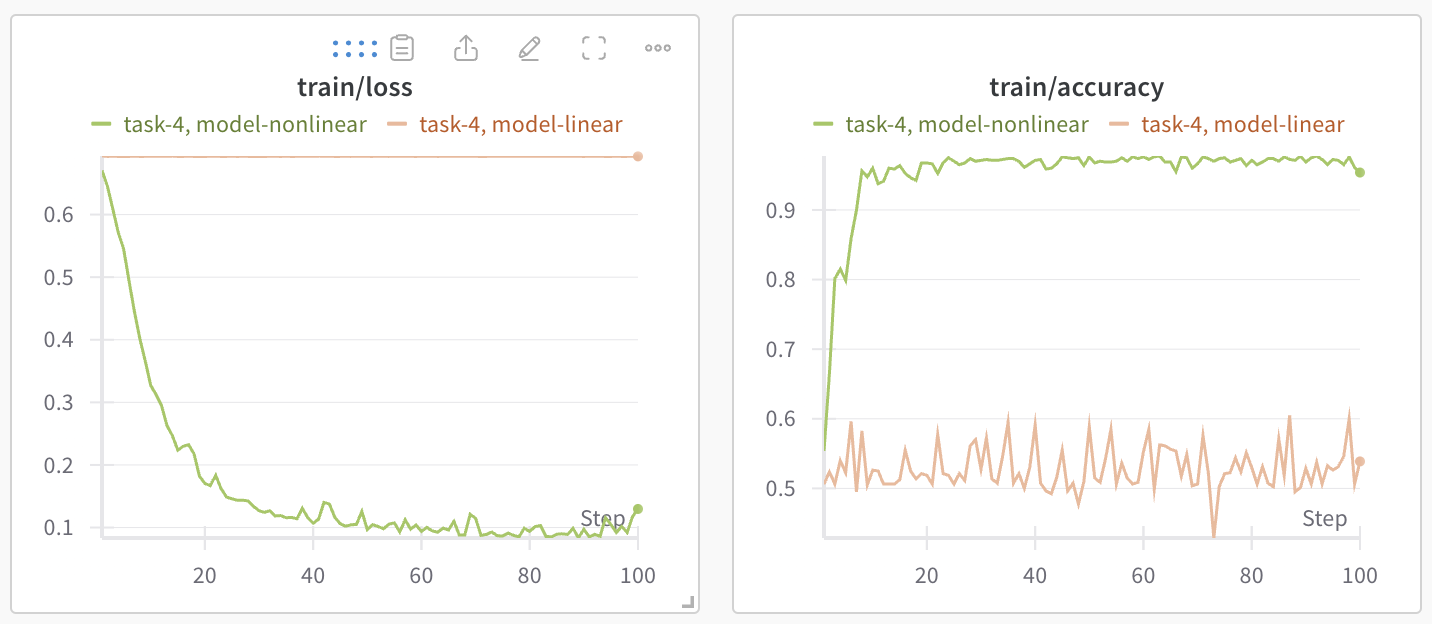

<p class='task' id='5'></p>

5\. Повторите задачу 2, реализовав логику ранней остановки. Для этого разделите данные на три части: обучающую, валидационную и тестовую. Остановите процесс обучения, если целевая метрика (F1) на валидации не увеличивалась в течении последних $k$ ($k$ - гиперпараметр метода) эпох. В момент остановки выведите сообщение с текущим номером эпохи. Сохраните номер эпохи, на которой процесс обучения был прерван, в виде summary данного запуска.

Помимо отслеживания метрик на обучающей и тестовой выборке, также отслеживайте метрики на валидационной выборке в процессе обучения.

Постройте таблицу `wandb.Table`, в которой содержится информация о:
* признаках объекта;
* правильном ответе;
* прогнозе модели;
* принадлежности к обучающему, валидационному или тестовому множеству.

Визуализируйте данную таблицу при помощи `wandb`.

Вставьте в текстовую ячейку скриншоты, демонстрирующие интерфейс `wandb` со всеми нужными визуализациями.

- [ ] Проверено на семинаре

In [33]:
dataset = TensorDataset(X, y)
dataset_train, temp_subset = random_split(dataset, [0.7, 0.3])
dataset_val, dataset_test = random_split(temp_subset, [0.67, 0.33])

dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=16)
dataloader_test = DataLoader(dataset_test, batch_size=16)

In [34]:
model_1 = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 2),
)

model_2 = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
)

model_3 = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
)

In [35]:
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.01)
criterion_1 = nn.CrossEntropyLoss()

optimizer_2 = optim.AdamW(model_2.parameters(), lr=0.01)
criterion_2 = nn.CrossEntropyLoss()

optimizer_3 = optim.AdamW(model_3.parameters(), lr=0.01)
criterion_3 = nn.CrossEntropyLoss()

In [36]:
def train(model, optimizer, criterion, num_epochs, patience, print_every=40, model_name='model'):
    best_f1 = 0
    epochs_no_improve = 0
    epoch_counter = 0

    best_model_state = model.state_dict()
    for epoch in range(1, num_epochs + 1):
        epoch_counter = epoch
        model.train()
        for x_batch, y_batch in dataloader_train:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with th.no_grad():
            X_train, y_train = dataset_train[:][0], dataset_train[:][1]
            y_pred_train = model(X_train)
            loss_train = criterion(y_pred_train, y_train)
            preds_train = th.argmax(y_pred_train, dim=1)
            acc_train = Accuracy(task='binary')(preds_train, y_train)
            f1_train = F1Score(task='binary')(preds_train, y_train)
        
            X_val, y_val = dataset_val[:][0], dataset_val[:][1]
            y_pred_val = model(X_val)
            loss_val = criterion(y_pred_val, y_val)
            preds_val = th.argmax(y_pred_val, dim=1)
            acc_val = Accuracy(task='binary')(preds_val, y_val)
            f1_val = F1Score(task='binary')(preds_val, y_val)
        
            X_test, y_test = dataset_test[:][0], dataset_test[:][1]
            y_pred_test = model(X_test)
            loss_test = criterion(y_pred_test, y_test)
            preds_test = th.argmax(y_pred_test, dim=1)
            acc_test = Accuracy(task='binary')(preds_test, y_test)
            f1_test = F1Score(task='binary')(preds_test, y_test)
        
        wandb.log({
            'epoch': epoch,
            'train/loss': loss_train.item(),
            'train/accuracy': acc_train.item(),
            'train/f1': f1_train.item(),
            'val/loss': loss_val.item(),
            'val/accuracy': acc_val.item(),
            'val/f1': f1_val.item(),
            'test/loss': loss_test.item(),
            'test/accuracy': acc_test.item(),
            'test/f1': f1_test.item(),
        })
        
        if epoch % print_every == 0 or epoch == 1:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {loss_train:.4f}, Train F1: {f1_train:.4f}, Val Loss: {loss_val:.4f}, Val F1: {f1_val:.4f}')
        
        if f1_val > best_f1:
            best_f1 = f1_val
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Ранняя остановка на эпохе: {epoch}')
                break
    
    model.eval()
    with th.no_grad():
        X_test, y_test = dataset_test[:][0], dataset_test[:][1]
        y_pred_test = model(X_test)
        preds_test = th.argmax(y_pred_test, dim=1)
        
        accuracy_test = Accuracy(task='binary')(preds_test, y_test)
        precision_test = Precision(task='binary')(preds_test, y_test)
        recall_test = Recall(task='binary')(preds_test, y_test)
        f1_test = F1Score(task='binary')(preds_test, y_test)
    
    wandb.summary['test/accuracy'] = accuracy_test.item()
    wandb.summary['test/precision'] = precision_test.item()
    wandb.summary['test/recall'] = recall_test.item()
    wandb.summary['test/f1'] = f1_test.item()
    wandb.summary['early_stop_epoch'] = epoch_counter
    
    X_all, y_all = dataset[:][0], dataset[:][1]
    model.eval()
    with th.no_grad():
        y_pred_all = model(X_all)
        preds_all = th.argmax(y_pred_all, dim=1)
    
    data = []
    for i in range(len(dataset)):
        features = X_all[i].cpu().numpy()
        label = y_all[i].item()
        pred = preds_all[i].item()
        if i in dataset_train.indices:
            set_membership = 'train'
        elif i in dataset_val.indices:
            set_membership = 'validation'
        elif i in dataset_test.indices:
            set_membership = 'test'
        data.append([features[0], features[1], label, pred, set_membership])
    
    table = wandb.Table(columns=['x1', 'x2', 'label', 'pred', 'subset'])
    for row in data:
        table.add_data(*row)
    
    wandb.log({'data_table': table})
    return best_model_state

In [37]:
models = [model_1, model_2, model_3]
optimizers = [optimizer_1, optimizer_2, optimizer_3]
criterions = [criterion_1, criterion_2, criterion_3]
configs = [
    {'num_epochs': 60, 'print_every': 20, 'patience': 20, 'model_name': 'task-5, model-1'},
    {'num_epochs': 40, 'print_every': 20, 'patience': 20, 'model_name': 'task-5, model-2'},
    {'num_epochs': 30, 'print_every': 15, 'patience': 20, 'model_name': 'task-5, model-3'},
]

In [38]:
for model, optimizer, criterion, config in zip(models, optimizers, criterions, configs):
    wandb.init(
        project='seminar-tutorial',
        name=config['model_name'],
        tags=['task-5'],
        config=config
    )
    train(model, optimizer, criterion, **config)
    wandb.finish()

Epoch 1/60, Train Loss: 0.6910, Train F1: 0.6750, Val Loss: 0.7037, Val F1: 0.6644
Epoch 20/60, Train Loss: 0.2150, Train F1: 0.9520, Val Loss: 0.2361, Val F1: 0.9447
Epoch 40/60, Train Loss: 0.1081, Train F1: 0.9785, Val Loss: 0.1330, Val F1: 0.9583
Ранняя остановка на эпохе: 48


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test/accuracy,▂▁▅▄▅▇▆▅▆▇▇▇████████████████████████████
test/f1,▆▁▇▆▆▇▇▆▇███████████████████████████████
test/loss,████▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▁▄▅▅▇▆▆▇▇█▇████████████████████████████
train/f1,▆▁▆▆▆▇▇▇▇███████████████████████████████
train/loss,███▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/accuracy,▁▁▄▅▄▆▅▅▆▇█▇▇▇██████████████████████████
val/f1,▆▁▆▆▆▇▆▆▆███████████████████████████████
val/loss,██▇▇▇▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
early_stop_epoch,48


Epoch 1/40, Train Loss: 0.6759, Train F1: 0.7379, Val Loss: 0.6854, Val F1: 0.7155
Epoch 20/40, Train Loss: 0.0843, Train F1: 0.9692, Val Loss: 0.1289, Val F1: 0.9538
Ранняя остановка на эпохе: 35


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test/accuracy,▃▁▆▇███▇███▇█▆█▇█████▇█▇███▇█▇██▇▇█
test/f1,▅▁▇▇███████▇█▇█▇█████████████▇██▇▇█
test/loss,██▅▄▃▃▂▂▁▁▂▂▁▄▁▁▂▁▂▁▁▁▁▂▁▁▁▂▁▂▂▁▂▁▁
train/accuracy,▃▁▆▇█▇█▆███▇█▆█▇▇████████▇█▇████▇██
train/f1,▅▁▆▇█▇█▇███▇█▆█████████████▇████▇██
train/loss,█▇▆▄▃▂▂▃▂▁▁▂▁▄▁▂▂▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▂▁▁
val/accuracy,▄▁▆▇█▇█▇███▇█▆██▇███████████████▇██
val/f1,▅▁▇▇█▇█▇███▇█▆██▇███████████████▇██
val/loss,██▆▄▃▃▂▃▂▂▂▂▁▅▁▂▂▁▂▁▁▁▂▂▁▁▁▂▁▂▁▂▃▁▂
early_stop_epoch,35


Epoch 1/30, Train Loss: 0.6114, Train F1: 0.6604, Val Loss: 0.6349, Val F1: 0.5075
Epoch 15/30, Train Loss: 0.1068, Train F1: 0.9522, Val Loss: 0.1710, Val F1: 0.9278
Ранняя остановка на эпохе: 25


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/accuracy,▁▇█▇█▇█▇▇▇▇▇█▇▇█▆▇▇█▆▇▇█▇
test/f1,▁▇███▇█▇▇█▇▇████▇███▇▇▇██
test/loss,█▂▂▂▁▂▁▁▂▂▂▂▂▂▁▁▂▁▂▁▃▂▂▁▂
train/accuracy,▁▇█▇▇▇██▇███▇▇▇▇▇▇██▇▇▇▇█
train/f1,▁██▇█▇██▇█████▇▇████▇▇▇██
train/loss,█▂▂▂▁▂▁▁▂▁▂▁▁▂▂▂▂▂▁▁▂▂▂▁▂
val/accuracy,▁▇████████▇███▇█▇▇██▆█▇█▇
val/f1,▁▇████████████▇█▇▇██▇███▇
val/loss,█▂▂▂▁▂▁▁▃▁▁▁▁▂▂▁▂▂▂▁▄▂▂▁▂
early_stop_epoch,25


Описание | Скрин
-|-
Таблица | ![Снимок экрана 2024-10-27 в 15.46.15.png](<attachment:Снимок экрана 2024-10-27 в 15.46.15.png>)
Тренировка | ![Снимок экрана 2024-10-27 в 15.48.30.png](<attachment:Снимок экрана 2024-10-27 в 15.48.30.png>)
Валидация | ![Снимок экрана 2024-10-27 в 15.47.21.png](<attachment:Снимок экрана 2024-10-27 в 15.47.21.png>)
Оценка | ![Снимок экрана 2024-10-27 в 15.47.09.png](<attachment:Снимок экрана 2024-10-27 в 15.47.09.png>)
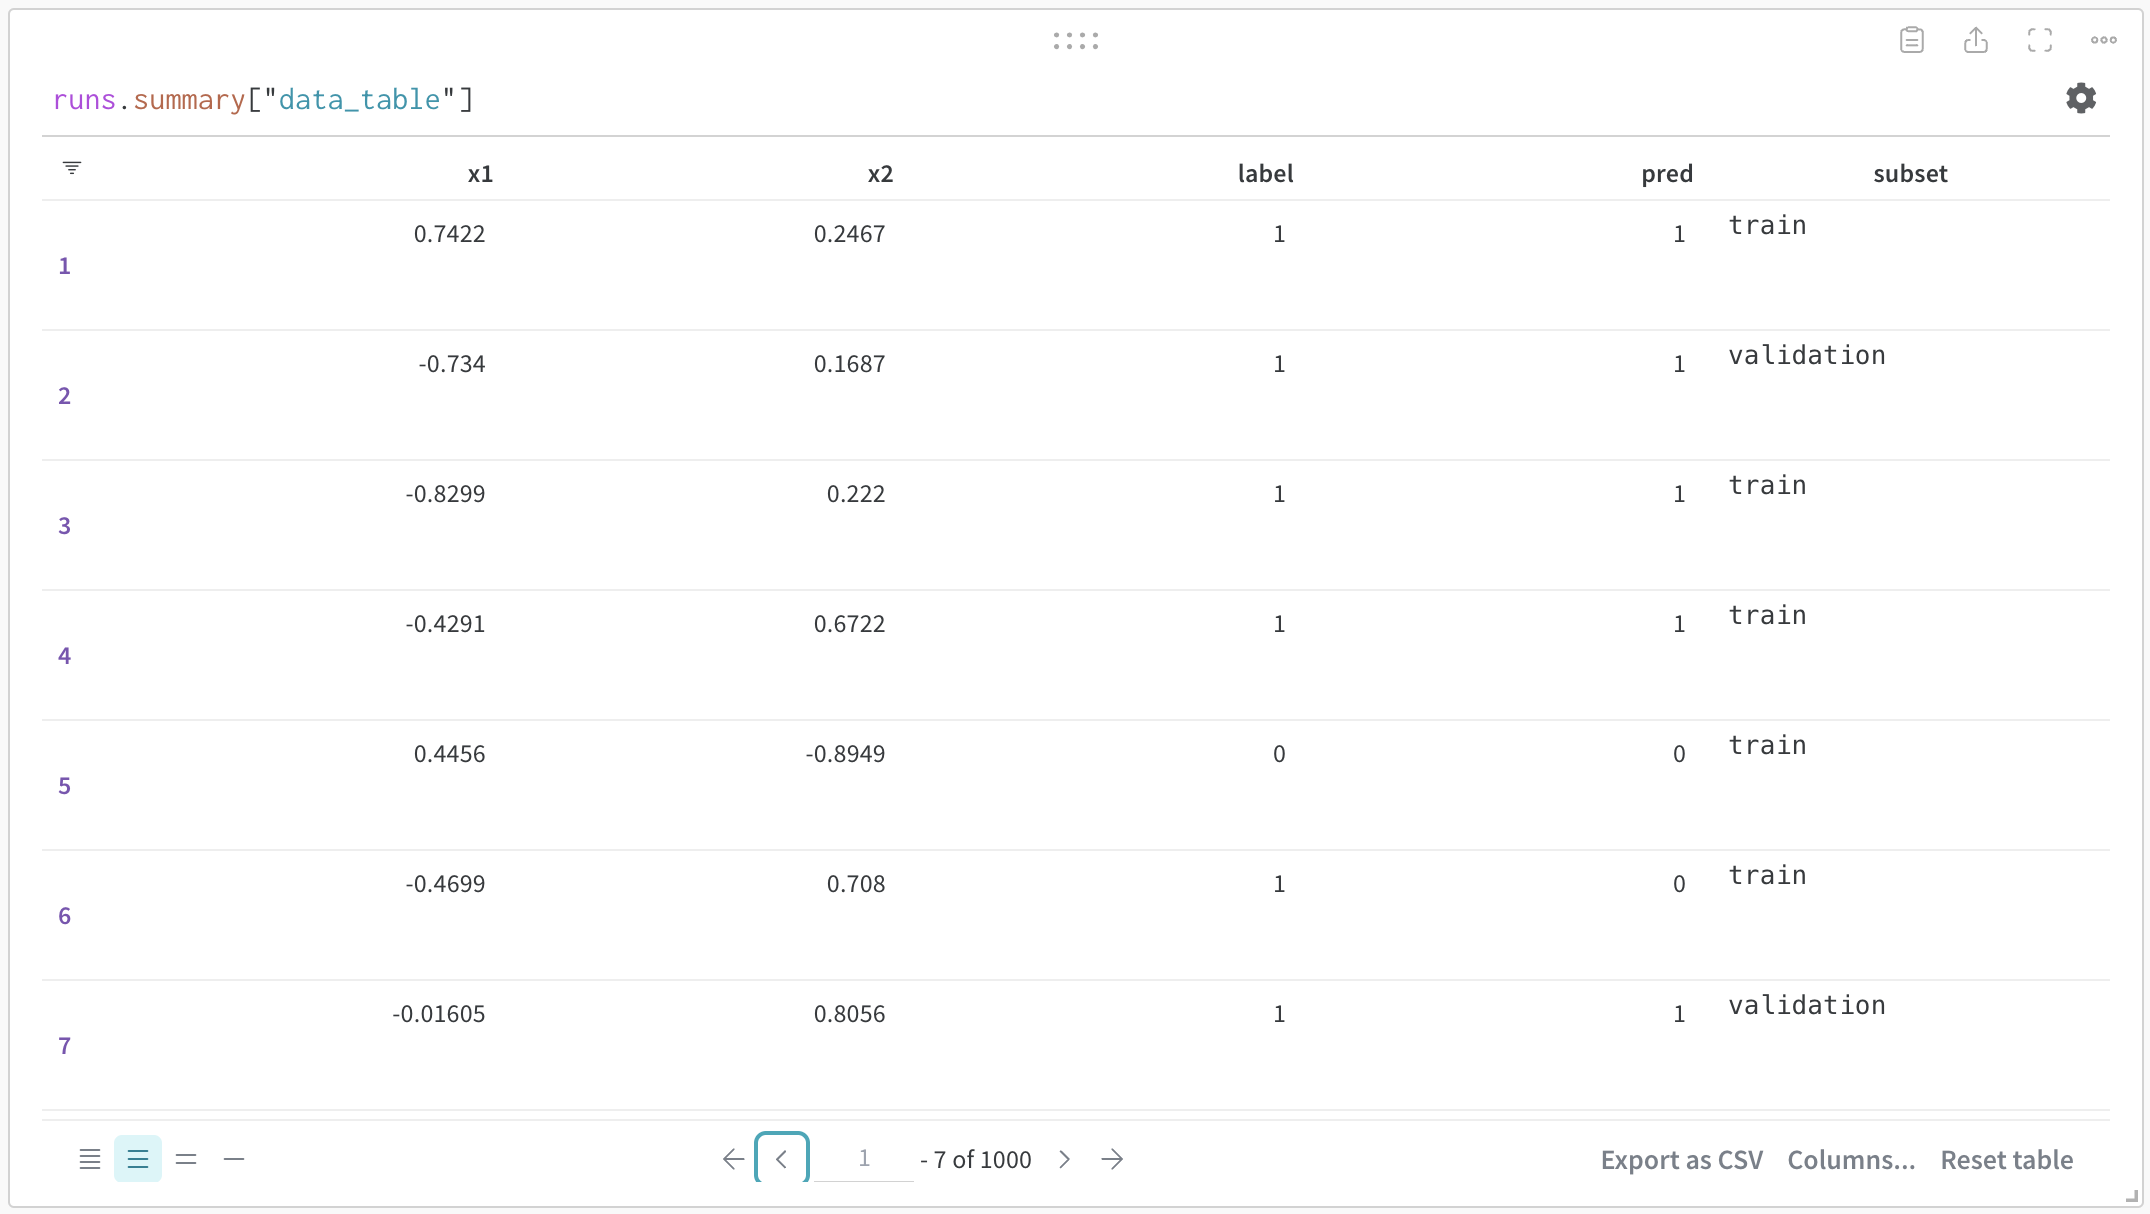
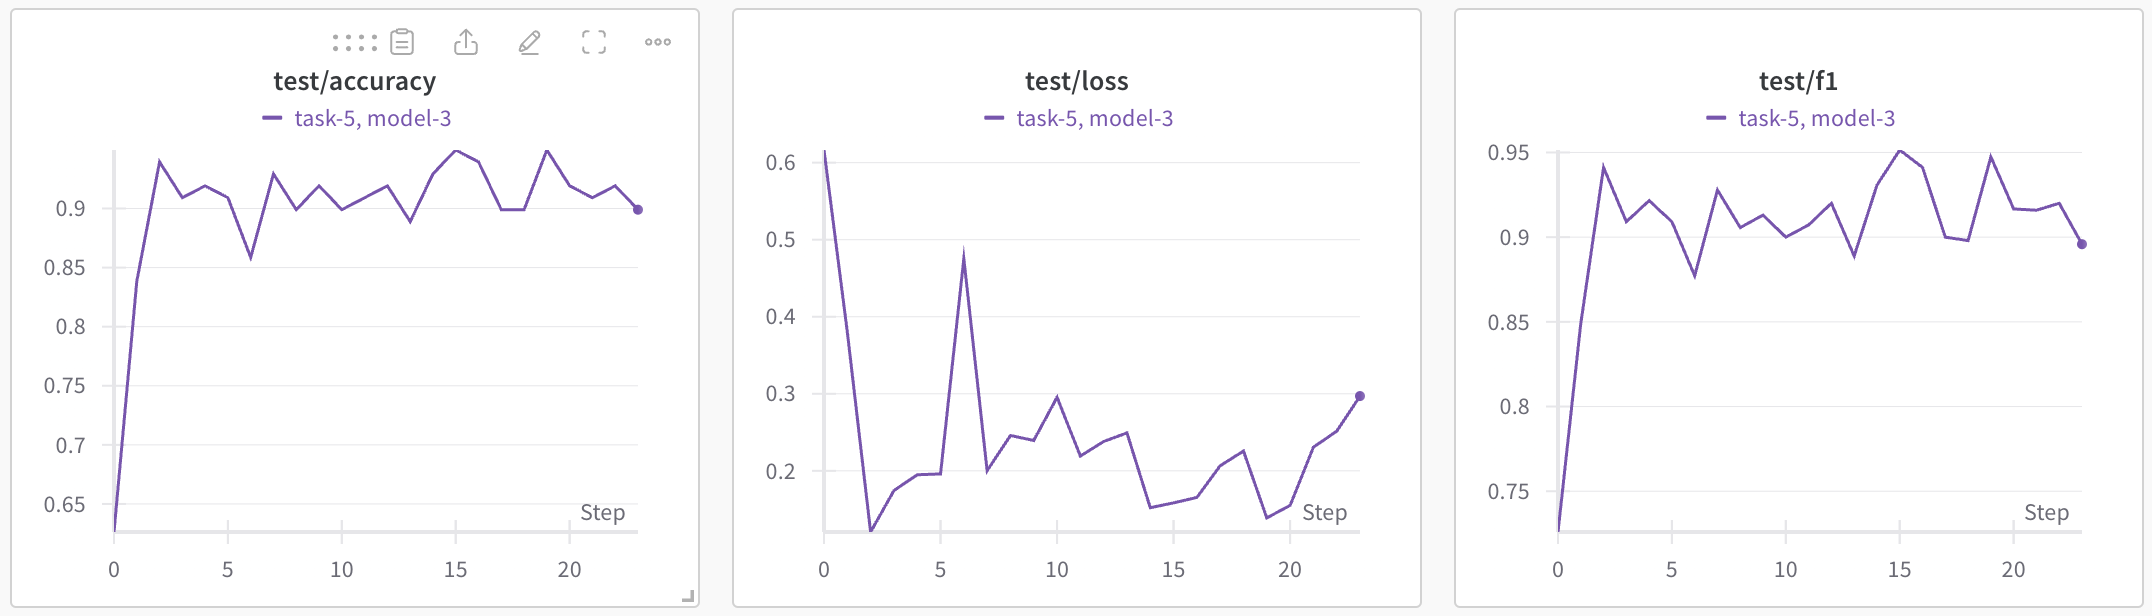
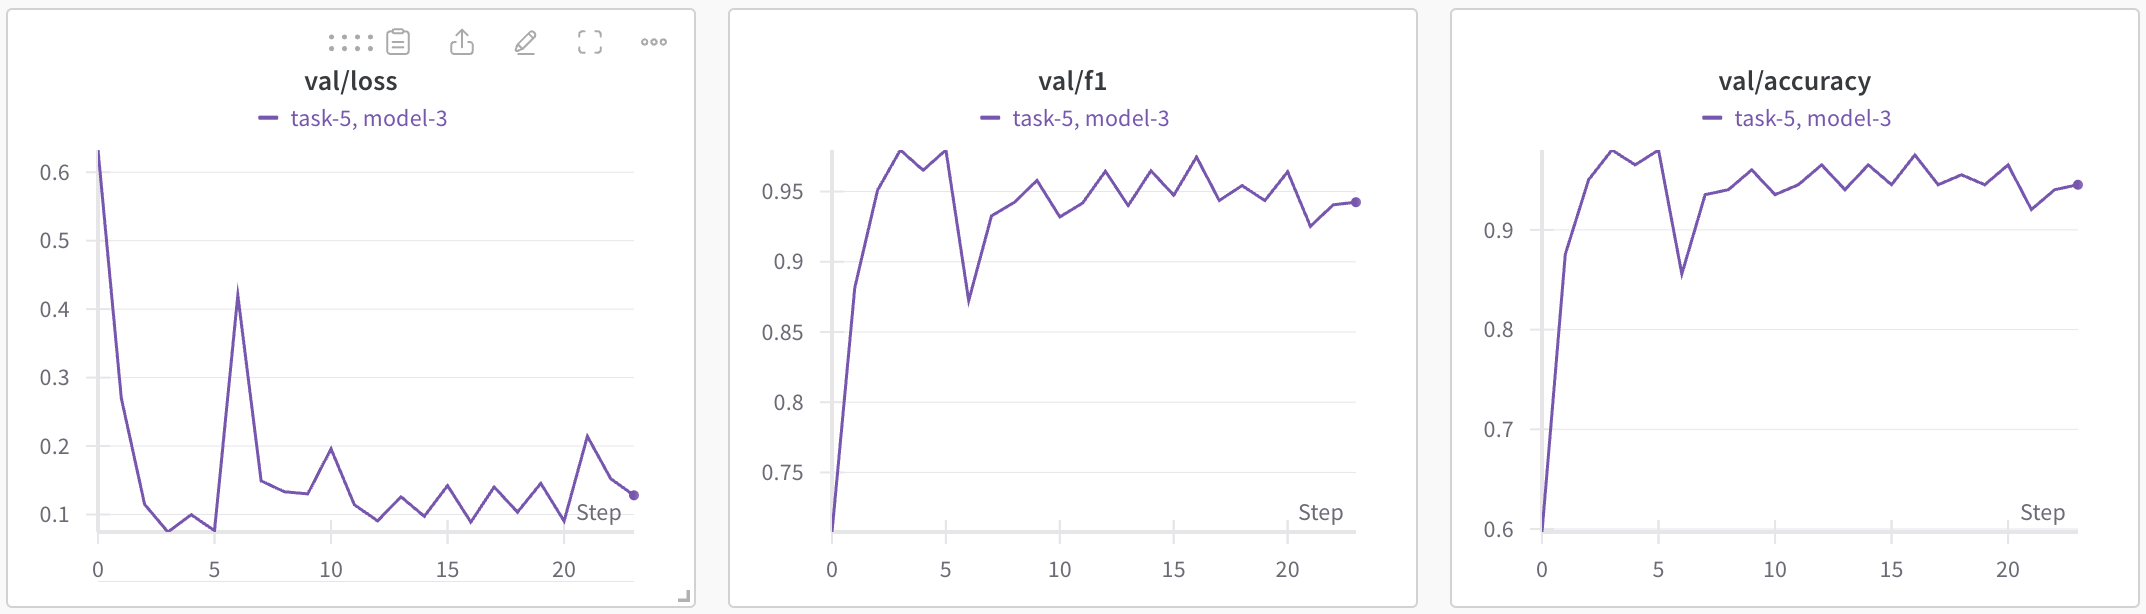
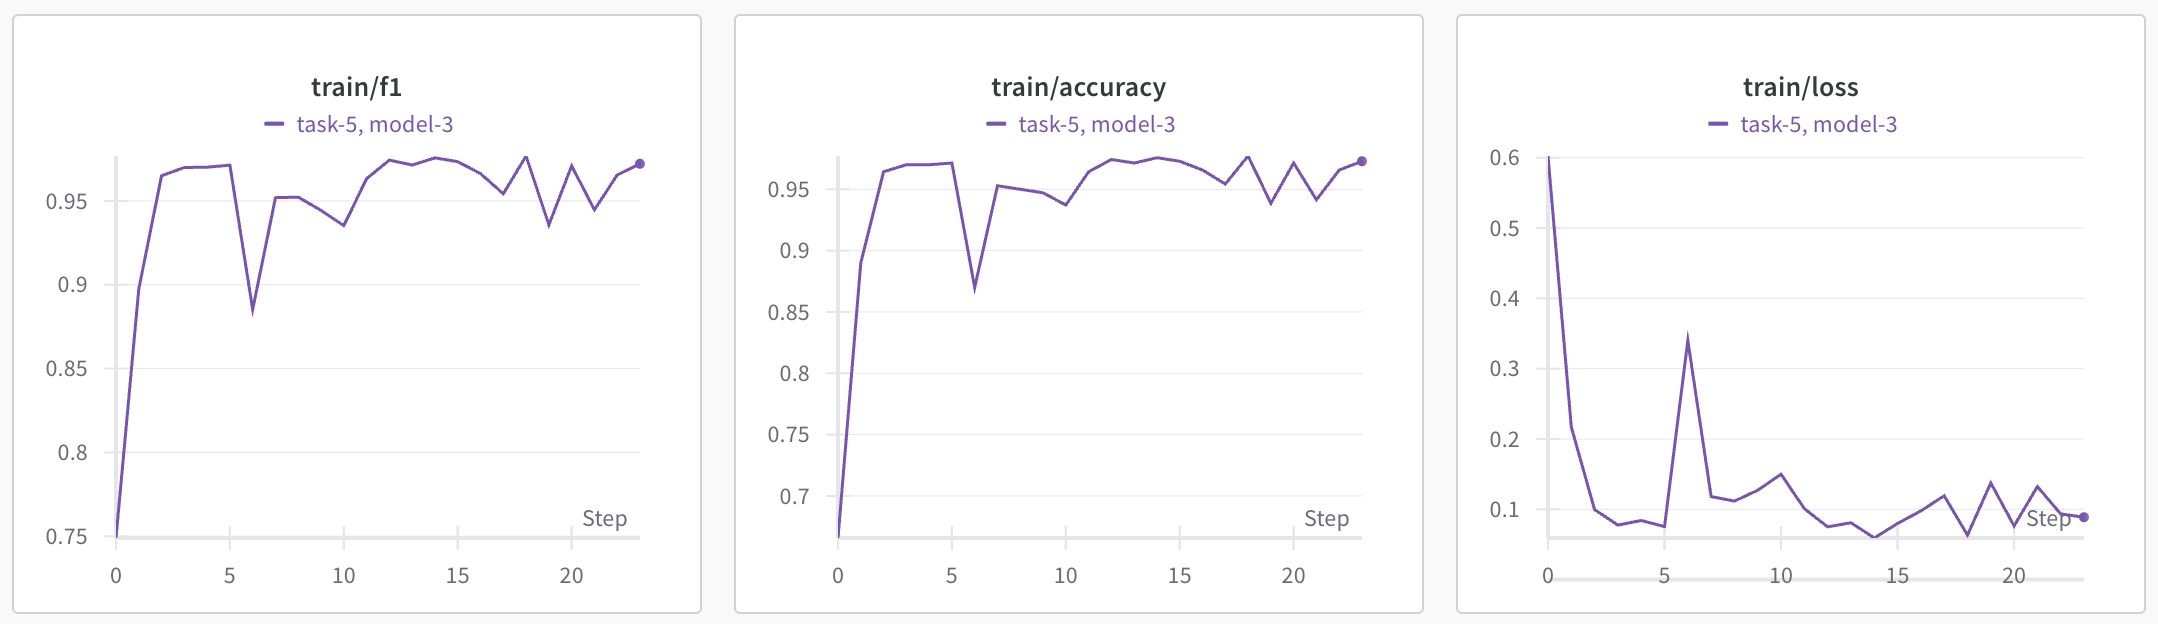